# Prepare libraries

In [ ]:
!pip install pyod
!pip install catboost
!pip install optuna
!pip install kmodes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import randint, uniform

from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from pyod.models.mad import MAD
from pyod.models.kde import KDE
from pyod.models.abod import ABOD
from pyod.models.ecod import ECOD
from pyod.models.lof import LOF

from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import normalized_mutual_info_score

import optuna
import warnings
warnings.filterwarnings('ignore')


In [ ]:
!gdown 1WMPTrDM5-ukpRnt6Yw0o6iOjW7I3Mica

Downloading...
From: https://drive.google.com/uc?id=1WMPTrDM5-ukpRnt6Yw0o6iOjW7I3Mica
To: /content/data.csv
100% 533k/533k [00:00<00:00, 7.96MB/s]


In [ ]:
pd.set_option('display.max_columns', None)

# Loading data and exploring the labels

In [ ]:
messed_up_df = pd.read_csv('data.csv')
messed_up_df.head()

Marital status;Application mode;Application order;Course;"Daytime/evening attendance\t";Previous qualification;Previous qualification (grade);Nacionality;Mother's qualification;Father's qualification;Mother's occupation;Father's occupation;Admission grade;Displaced;Educational special needs;Debtor;Tuition fees up to date;Gender;Scholarship holder;Age at enrollment;International;Curricular units 1st sem (credited);Curricular units 1st sem (enrolled);Curricular units 1st sem (evaluations);Curricular units 1st sem (approved);Curricular units 1st sem (grade);Curricular units 1st sem (without evaluations);Curricular units 2nd sem (credited);Curricular units 2nd sem (enrolled);Curricular units 2nd sem (evaluations);Curricular units 2nd sem (approved);Curricular units 2nd sem (grade);Curricular units 2nd sem (without evaluations);Unemployment rate;Inflation rate;GDP;Target
0  1;17;5;171;1;1;122.0;1;19;12;5;9;127.3;1;0;0;1...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1  1;15;1;9254;1;1;160.0;1;1;3;3;3;142.5;1;0;0;0;...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2  1;1;5;9070;1;1;122.0;1;37;37;9;9;124.8;1;0;0;0...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
3  1;17;2;9773;1;1;122.0;1;38;37;5;3;119.6;1;0;0;...                                                                                                                                                                                                                                                                                                                                                                                                                                          

All columns are contained in a single one. Let's fix it.

In [ ]:
seperated_columns = messed_up_df.columns[0].split(';')
df = pd.DataFrame(columns=seperated_columns)

for ind in range(len(messed_up_df)):
  seperated_cells = messed_up_df.iloc[ind][0].split(';')
  converted_cells = list(map(float, seperated_cells[:-1]))
  converted_cells.append(seperated_cells[-1])
  df.loc[ind] = converted_cells

df.rename(columns = {'"Daytime/evening attendance\t"': 'Daytime/evening attendance'}, inplace = True)

In [ ]:
df.head()

Marital status  Application mode  Application order  Course  \
0             1.0              17.0                5.0   171.0   
1             1.0              15.0                1.0  9254.0   
2             1.0               1.0                5.0  9070.0   
3             1.0              17.0                2.0  9773.0   
4             2.0              39.0                1.0  8014.0   

   Daytime/evening attendance  Previous qualification  \
0                         1.0                     1.0   
1                         1.0                     1.0   
2                         1.0                     1.0   
3                         1.0                     1.0   
4                         0.0                     1.0   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0          1.0                    19.0   
1                           160.0          1.0                     1.0   
2                           122.0          1.0                    37.0   
3                           122.0          1.0                    38.0   
4                           100.0          1.0                    37.0   

   Father's qualification  Mother's occupation  Father's occupation  \
0                    12.0                  5.0                  9.0   
1                     3.0                  3.0                  3.0   
2                    37.0                  9.0                  9.0   
3                    37.0                  5.0                  3.0   
4                    38.0                  9.0                  9.0   

   Admission grade  Displaced  Educational special needs  Debtor  \
0            127.3        1.0                        0.0     0.0   
1            142.5        1.0                        0.0     0.0   
2            124.8        1.0                        0.0     0.0   
3            119.6        1.0                        0.0     0.0   
4            141.5        0.0                        0.0     0.0   

   Tuition fees up to date  Gender  Scholarship holder  Age at enrollment  \
0                      1.0     1.0                 0.0               20.0   
1                      0.0     1.0                 0.0               19.0   
2                      0.0     1.0                 0.0               19.0   
3                      1.0     0.0                 0.0               20.0   
4                      1.0     0.0                 0.0               45.0   

   International  Curricular units 1st sem (credited)  \
0            0.0                                  0.0   
1            0.0                                  0.0   
2            0.0                                  0.0   
3            0.0                                  0.0   
4            0.0                                  0.0   

   Curricular units 1st sem (enrolled)  \
0                                  0.0   
1                                  6.0   
2                                  6.0   
3                                  6.0   
4                                  6.0   

   Curricular units 1st sem (evaluations)  \
0                                     0.0   
1                                     6.0   
2                                     0.0   
3                                     8.0   
4                                     9.0   

   Curricular units 1st sem (approved)  Curricular units 1st sem (grade)  \
0                                  0.0                          0.000000   
1                                  6.0                         14.000000   
2                                  0.0                          0.000000   
3                                  6.0                         13.428571   
4                                  5.0                         12.333333   

   Curricular units 1st sem (without evaluations)  \
0                                             0.0   
1                                             0.0   
2                                   

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   float64
 1   Application mode                                4424 non-null   float64
 2   Application order                               4424 non-null   float64
 3   Course                                          4424 non-null   float64
 4   Daytime/evening attendance                      4424 non-null   float64
 5   Previous qualification                          4424 non-null   float64
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   float64
 8   Mother's qualification                          4424 non-null   float64
 9   Father's qualification                        

There is no null values in our dataset, and all the data is float64 except for the Target (what we are trying to predict), and that's fine, but we will transform the data later on to make sense of it during visulization.

In [ ]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
4419    False
4420    False
4421    False
4422    False
4423    False
Length: 4424, dtype: bool

There is also no duplicated rows.

# Categorical Data Transformation

In [ ]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, category_dict):
        self.category_dict = category_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for column, mapping in self.category_dict.items():
            X_copy[column] = X_copy[column].map(mapping)
        return X_copy

In [ ]:
material_status_label = "Marital status"
marital_status_dict = {
            1: 'single',
            2: 'married',
            3: 'widower',
            4: 'divorced',
            5: 'facto union',
            6: 'legally separated'
        }

In [ ]:
application_mode_label = "Application mode"
application_mode_dict = {
            1: '1st phase - general contingent',
            2: 'Ordinance No. 612/93',
            5: '1st phase - special contingent (Azores Island)',
            7: 'Holders of other higher courses',
            10: 'Ordinance No. 854-B/99',
            15: 'International student (bachelor)',
            16: '1st phase - special contingent (Madeira Island)',
            17: '2nd phase - general contingent',
            18: '3rd phase - general contingent',
            26: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
            27: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
            39: 'Over 23 years old',
            42: 'Transfer',
            43: 'Change of course',
            44: 'Technological specialization diploma holders',
            51: 'Change of institution/course',
            53: 'Short cycle diploma holders',
            57: 'Change of institution/course (International)'
        }

In [ ]:
course_label = "Course"
course_dict = {
            33: 'Biofuel Production Technologies',
            171: 'Animation and Multimedia Design',
            8014: 'Social Service (evening attendance)',
            9003: 'Agronomy',
            9070: 'Communication Design',
            9085: 'Veterinary Nursing',
            9119: 'Informatics Engineering',
            9130: 'Equinculture',
            9147: 'Management',
            9238: 'Social Service',
            9254: 'Tourism',
            9500: 'Nursing',
            9556: 'Oral Hygiene',
            9670: 'Advertising and Marketing Management',
            9773: 'Journalism and Communication',
            9853: 'Basic Education',
            9991: 'Management (evening attendance)'
        }

In [ ]:
previous_qualification_label = "Previous qualification"
previous_qualification_dict = {
            1: 'Secondary education',
            2: 'Higher education - bachelor\'s degree',
            3: 'Higher education - degree',
            4: 'Higher education - master\'s',
            5: 'Higher education - doctorate',
            6: 'Frequency of higher education',
            9: '12th year of schooling - not completed',
            10: '11th year of schooling - not completed',
            12: 'Other - 11th year of schooling',
            14: '10th year of schooling',
            15: '10th year of schooling - not completed',
            19: 'Basic education 3rd cycle (9th/10th/11th year) or equiv.',
            38: 'Basic education 2nd cycle (6th/7th/8th year) or equiv.',
            39: 'Technological specialization course',
            40: 'Higher education - degree (1st cycle)',
            42: 'Professional higher technical course',
            43: 'Higher education - master (2nd cycle)'
        }

In [ ]:
nacionality_label = "Nacionality"
nacionality_dict = {
    1: 'Portuguese',
    2: 'German',
    6: 'Spanish',
    11: 'Italian',
    13: 'Dutch',
    14: 'English',
    17: 'Lithuanian',
    21: 'Angolan',
    22: 'Cape Verdean',
    24: 'Guinean',
    25: 'Mozambican',
    26: 'Santomean',
    32: 'Turkish',
    41: 'Brazilian',
    62: 'Romanian',
    100: 'Moldova (Republic of)',
    101: 'Mexican',
    103: 'Ukrainian',
    105: 'Russian',
    108: 'Cuban',
    109: 'Colombian'
}

In [ ]:
mothers_qualification_label = "Mother's qualification"
mothers_qualification_dict = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: 'Higher Education - Bachelor\'s Degree',
    3: 'Higher Education - Degree',
    4: 'Higher Education - Master\'s',
    5: 'Higher Education - Doctorate',
    6: 'Frequency of Higher Education',
    9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed',
    11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling',
    14: '10th Year of Schooling',
    18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    22: 'Technical-professional course',
    26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed',
    30: '8th year of schooling',
    34: 'Unknown',
    35: 'Can\'t read or write',
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course',
    43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)'
}

In [ ]:
fathers_qualification_label = "Father's qualification"
fathers_qualification_dict = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: 'Higher Education - Bachelor\'s Degree',
    3: 'Higher Education - Degree',
    4: 'Higher Education - Master\'s',
    5: 'Higher Education - Doctorate',
    6: 'Frequency of Higher Education',
    9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed',
    11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling',
    13: '2nd year complementary high school course',
    14: '10th Year of Schooling',
    18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    20: 'Complementary High School Course',
    22: 'Technical-professional course',
    25: 'Complementary High School Course - not concluded',
    26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed',
    30: '8th year of schooling',
    31: 'General Course of Administration and Commerce',
    33: 'Supplementary Accounting and Administration',
    34: 'Unknown',
    35: 'Can\'t read or write',
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course',
    43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)'
}

In [ ]:
mothers_occupation_label = "Mother's occupation"
mothers_occupation_dict = {
    0: 'Student',
    1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    90: 'Other Situation',
    99: '(blank)',
    122: 'Health professionals',
    123: 'teachers',
    125: 'Specialists in information and communication technologies (ICT)',
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff',
    151: 'personal service workers',
    152: 'sellers',
    153: 'Personal care workers and the like',
    171: 'Skilled construction workers and the like, except electricians',
    173: 'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like',
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    191: 'cleaning workers',
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants'
}


In [ ]:
fathers_occupation_label = "Father's occupation"
fathers_occupation_dict = {
    0: 'Student',
    1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    90: 'Other Situation',
    99: '(blank)',
    101: 'Armed Forces Officers',
    102: 'Armed Forces Sergeants',
    103: 'Other Armed Forces personnel',
    112: 'Directors of administrative and commercial services',
    114: 'Hotel, catering, trade and other services directors',
    121: 'Specialists in the physical sciences, mathematics, engineering and related techniques',
    122: 'Health professionals',
    123: 'teachers',
    124: 'Specialists in finance, accounting, administrative organization, public and commercial relations',
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    135: 'Information and communication technology technicians',
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff',
    151: 'personal service workers',
    152: 'sellers',
    153: 'Personal care workers and the like',
    154: 'Protection and security services personnel',
    161: 'Market-oriented farmers and skilled agricultural and animal production workers',
    163: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence',
    171: 'Skilled construction workers and the like, except electricians',
    172: 'Skilled workers in metallurgy, metalworking and similar',
    174: 'Skilled workers in electricity and electronics',
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    181: 'Fixed plant and machine operators',
    182: 'assembly workers',
    183: 'Vehicle drivers and mobile equipment operators',
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants',
    195: 'Street vendors (except food) and street service providers'
}


In [ ]:
transform_categorical_pipeline = Pipeline(steps=[
    ('marital_status', CategoricalTransformer({material_status_label: marital_status_dict})),
    ('application_mode', CategoricalTransformer({application_mode_label: application_mode_dict})),
    ('course', CategoricalTransformer({course_label: course_dict})),
    ('previous_qualification', CategoricalTransformer({previous_qualification_label: previous_qualification_dict})),
    ('nacionality', CategoricalTransformer({nacionality_label: nacionality_dict})),
    ('mothers_qualification', CategoricalTransformer({mothers_qualification_label: mothers_qualification_dict})),
    ('fathers_qualification', CategoricalTransformer({fathers_qualification_label: fathers_qualification_dict})),
    ('mothers_occupation', CategoricalTransformer({mothers_occupation_label: mothers_occupation_dict})),
    ('fathers_occupation', CategoricalTransformer({fathers_occupation_label: fathers_occupation_dict})),
])


In [ ]:
transformed_df = transform_categorical_pipeline.transform(X=df)

We will add two columns and we will discuss the reason later on in the notebook.

In [ ]:
transformed_df['Is Graduate'] = df['Target'].apply(lambda x: x == 'Graduate')
transformed_df['Is Dropout'] = df['Target'].apply(lambda x: x == 'Dropout')

In [ ]:
label_encoder = preprocessing.LabelEncoder()

transformed_df['Target']= label_encoder.fit_transform(transformed_df['Target'])

In [ ]:
list(label_encoder.inverse_transform([0, 1, 2]))

['Dropout', 'Enrolled', 'Graduate']

# Data splitting

Before any visulization or preprocessing data takes place, we will split our dataset. This will helps us avoid data leakage.

In [ ]:
X_transformed = transformed_df.drop(['Target', 'Is Graduate', 'Is Dropout'], axis=1)
y_transformed = transformed_df[['Target', 'Is Graduate', 'Is Dropout']]

X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y_transformed, test_size=0.3, random_state=42)

In [ ]:
X = df.drop(['Target'], axis=1)
y = df[['Target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
x_train = X_train
x_test = X_test

# Correlation and PPS Tests

In [ ]:
lr_original = LogisticRegression(max_iter=1000)
lr_original.fit(X_train, y_train)
y_pred_original = lr_original.predict(X_test)

accuracy_original = accuracy_score(y_test, y_pred_original)
accuracy_original

0.7168674698795181

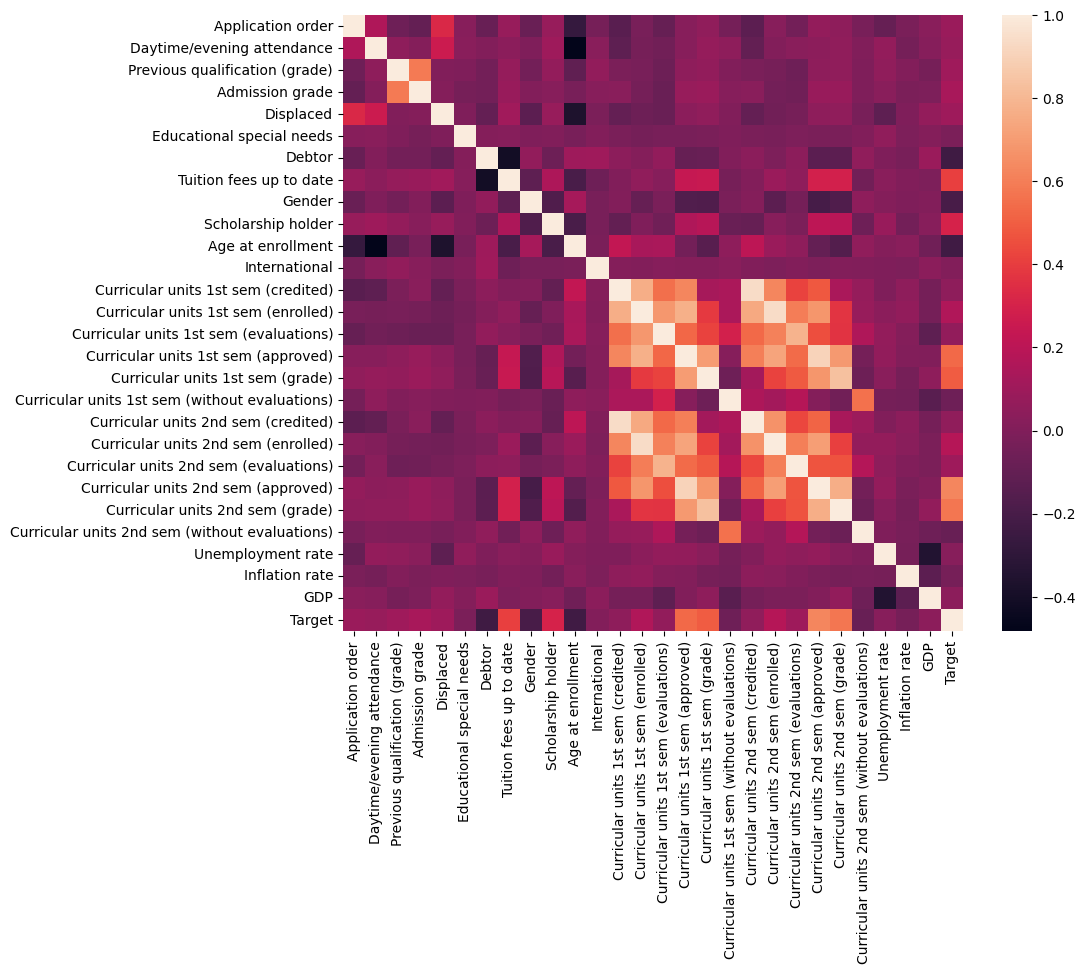

In [ ]:
train = pd.concat([X_train_transformed, y_train_transformed], axis=1)
numerical_df = train.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix)
plt.show()

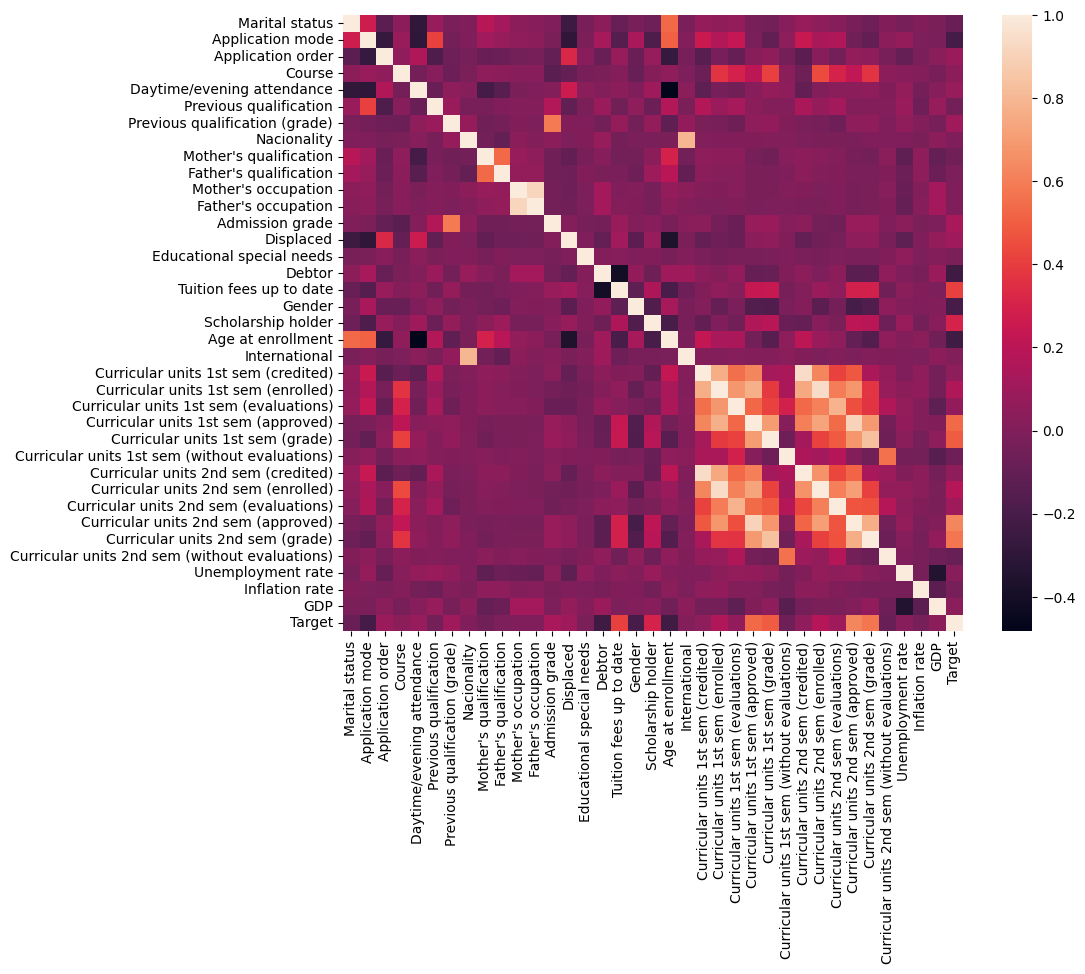

In [ ]:
numerical_df = pd.concat([X_train, train['Target']], axis=1)

correlation_matrix = numerical_df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix)
plt.show()

In [ ]:
threshold = 0.1
low_correlation_features = correlation_matrix[correlation_matrix['Target'].abs() < threshold].index.tolist()

filtered_df = numerical_df.drop(low_correlation_features, axis=1)


In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train.drop(low_correlation_features, axis=1), y_train)
y_pred = lr.predict(X_test.drop(low_correlation_features, axis=1))

accuracy_original = accuracy_score(y_test, y_pred)
accuracy_original

0.7620481927710844

Deleting low correlation values improved our model.

# Outliers Detection and Preprocessing in Numerical Data

## Interquartile Range (IQR)

In [ ]:
columns_num = [col for col in df.columns[21:] if col != 'Target'] + ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment']
#all columns ( numbers )

In [ ]:
lr_original = LogisticRegression(max_iter=1000)
lr_original.fit(X_train, y_train)
y_pred_original = lr_original.predict(X_test)

accuracy_original = accuracy_score(y_test, y_pred_original)
accuracy_original

0.7168674698795181

In [ ]:
def fill_outliers_with_mean(df, column, q1, q3, factor):
    quartile1 = df[column].quantile(q1)
    quartile3 = df[column].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + factor * interquantile_range
    low_limit = quartile1 - factor * interquantile_range
    outliers = df[(df[column] > up_limit) | (df[column] < low_limit)][column]
    df.loc[outliers.index, column] = df[column].mean()
    return df

def choose_best_params(df, column):


    X = df.drop(['Target'], axis=1)
    y = df[['Target']]
    lr_modified = LogisticRegression(max_iter=1000)
    lr_modified.fit(X, y)
    y_pred_modified = lr_modified.predict(X_test)

    best_accuracy = accuracy_score(y_test, y_pred_modified)

    best_params = (0, 0, 0)
    best_df = df.copy()

    q1_values = [0.1, 0.2, 0.25, 0.3, 0.4]
    q3_values = [0.6, 0.7, 0.75, 0.8, 0.9]
    factor_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

    for q1 in q1_values:
        for q3 in q3_values:
            for factor in factor_values:
                train = fill_outliers_with_mean(df.copy(), column, q1, q3, factor)
                X = train.drop(['Target'], axis=1)
                y = train[['Target']]
                lr_modified = LogisticRegression(max_iter=1000)
                lr_modified.fit(X, y)
                y_pred_modified = lr_modified.predict(X_test)

                accuracy_modified = accuracy_score(y_test, y_pred_modified)
                #print(f'q1: {q1}, q3: {q3}, factor: {factor}, accuracy: {accuracy_modified}')

                if accuracy_modified > best_accuracy:
                    best_accuracy = accuracy_modified
                    best_params = (q1, q3, factor)
                    best_df = train

    print(f'Best accuracy: {best_accuracy} with params q1: {best_params[0]}, q3: {best_params[1]}, factor: {best_params[2]}, name_col: {column}')
    return best_df

Detecting outliers and processing them in all `columns_num` seemed to improve our base model, hence, we will keep these parameters in the final model.

In [ ]:
temp_df = pd.concat([X_train, y_train], axis=1)
for col in columns_num :
  temp_df = choose_best_params(temp_df, col)

Best accuracy: 0.7228915662650602 with params q1: 0.1, q3: 0.9, factor: 1.0, name_col: Curricular units 1st sem (credited)
Best accuracy: 0.7289156626506024 with params q1: 0.3, q3: 0.9, factor: 1.0, name_col: Curricular units 1st sem (enrolled)
Best accuracy: 0.7289156626506024 with params q1: 0, q3: 0, factor: 0, name_col: Curricular units 1st sem (evaluations)
Best accuracy: 0.7289156626506024 with params q1: 0, q3: 0, factor: 0, name_col: Curricular units 1st sem (approved)
Best accuracy: 0.7289156626506024 with params q1: 0, q3: 0, factor: 0, name_col: Curricular units 1st sem (grade)
Best accuracy: 0.7289156626506024 with params q1: 0, q3: 0, factor: 0, name_col: Curricular units 1st sem (without evaluations)
Best accuracy: 0.7289156626506024 with params q1: 0, q3: 0, factor: 0, name_col: Curricular units 2nd sem (credited)
Best accuracy: 0.7289156626506024 with params q1: 0, q3: 0, factor: 0, name_col: Curricular units 2nd sem (enrolled)
Best accuracy: 0.7289156626506024 with pa

In [ ]:
temp_df2 = pd.concat([X_train, y_train], axis=1)

In [ ]:
temp_df_Age = choose_best_params(temp_df, 'Age at enrollment')

Best accuracy: 0.733433734939759 with params q1: 0.25, q3: 0.8, factor: 1.5


Detecting outliers and processing them in `Age at enrollment` seemed to improve our base model, hence, we will keep these parameters in the final model.

In [ ]:
temp_df_grade = choose_best_params(temp_df, 'Previous qualification (grade)')

Best accuracy: 0.7364457831325302 with params q1: 0.1, q3: 0.6, factor: 1.0


Detecting outliers and processing them in `Previous qualification (grade)` seemed to improve our base model, hence, we will keep these parameters in the final model.

In [ ]:
temp_df_Application_order = choose_best_params(temp_df, 'Application order')

Best accuracy: 0.7364457831325302 with params q1: 0.1, q3: 0.9, factor: 2.0


## Median Absolute Deviation (MAD)

In [ ]:
def fill_outliers_with_mean_MAD(df, column, threshold):
    model = MAD(threshold=threshold)
    predictions = model.fit_predict(df[column].to_numpy().reshape(-1, 1))
    outliers = df[predictions == 1][column]
    df.loc[outliers.index, column] = df[column].mean()
    return df

def choose_best_params_MAD(df, column):
    X = df.drop(['Target'], axis=1)
    y = df[['Target']]
    lr_modified = LogisticRegression(max_iter=1000)
    lr_modified.fit(X, y)
    y_pred_modified = lr_modified.predict(X_test)

    best_accuracy = accuracy_score(y_test, y_pred_modified)
    best_params = 0
    best_df = df.copy()

    threshold_values = np.arange(0.5, 10.5, 0.5)

    for threshold in threshold_values:
        train = fill_outliers_with_mean_MAD(df.copy(), column, threshold)
        X = train.drop(['Target'], axis=1)
        y = train[['Target']]
        lr_modified = LogisticRegression(max_iter=1000)
        lr_modified.fit(X, y)
        y_pred_modified = lr_modified.predict(X_test)

        accuracy_modified = accuracy_score(y_test, y_pred_modified)
        #print(f'threshold: {threshold}, accuracy: {accuracy_modified}')

        if accuracy_modified > best_accuracy:
            best_accuracy = accuracy_modified
            best_params = threshold
            best_df = train

    print(f'Best accuracy: {best_accuracy} with threshold: {best_params}, name_col: {column}')
    return best_df

In [ ]:
temp_df_MAD = pd.concat([X_train, y_train], axis=1)
for col in columns_num :
  temp_df_MAD = choose_best_params_MAD(temp_df_MAD, col)

Best accuracy: 0.7168674698795181 with threshold: 0, name_col: Curricular units 1st sem (credited)
Best accuracy: 0.7228915662650602 with threshold: 4.0, name_col: Curricular units 1st sem (enrolled)
Best accuracy: 0.7228915662650602 with threshold: 0, name_col: Curricular units 1st sem (evaluations)
Best accuracy: 0.7228915662650602 with threshold: 0, name_col: Curricular units 1st sem (approved)
Best accuracy: 0.7228915662650602 with threshold: 0, name_col: Curricular units 1st sem (grade)
Best accuracy: 0.7319277108433735 with threshold: 4.0, name_col: Curricular units 1st sem (without evaluations)
Best accuracy: 0.7319277108433735 with threshold: 0, name_col: Curricular units 2nd sem (credited)
Best accuracy: 0.7319277108433735 with threshold: 0, name_col: Curricular units 2nd sem (enrolled)
Best accuracy: 0.7319277108433735 with threshold: 0, name_col: Curricular units 2nd sem (evaluations)
Best accuracy: 0.7319277108433735 with threshold: 0, name_col: Curricular units 2nd sem (ap

## Kernel Density Estimation (KDE)

In [ ]:
def fill_outliers_with_mean_KDE(df, column, band_width):

    model = KDE(bandwidth=band_width)
    predictions = model.fit_predict(df[column].to_numpy().reshape(-1, 1))
    outliers = df[predictions == 1][column]
    df.loc[outliers.index, column] = df[column].mean()
    return df

def choose_best_params_KDE(df, column):
    X = df.drop(['Target'], axis=1)
    y = df[['Target']]
    lr_modified = LogisticRegression(max_iter=1000)
    lr_modified.fit(X, y)
    y_pred_modified = lr_modified.predict(X_test)

    best_accuracy = accuracy_score(y_test, y_pred_modified)
    best_params = 0
    best_df = df.copy()

    bandwidths_values = np.arange(0.5, 10.5, 0.5)

    for bandwidth in bandwidths_values:
        train = fill_outliers_with_mean_KDE(df.copy(), column, bandwidth)
        X = train.drop(['Target'], axis=1)
        y = train[['Target']]
        lr_modified = LogisticRegression(max_iter=1000)
        lr_modified.fit(X, y)
        y_pred_modified = lr_modified.predict(X_test)

        accuracy_modified = accuracy_score(y_test, y_pred_modified)
        #print(f'threshold: {threshold}, accuracy: {accuracy_modified}')

        if accuracy_modified > best_accuracy:
            best_accuracy = accuracy_modified
            best_params = bandwidth
            best_df = train

    print(f'Best accuracy: {best_accuracy} with threshold: {best_params}, name_col: {column}')
    return best_df

In [ ]:
temp_df_KDE = pd.concat([X_train, y_train], axis=1)
for col in columns_num :
  temp_df_KDE = choose_best_params_KDE(temp_df_KDE, col)

Best accuracy: 0.7191265060240963 with bandwidth: 0.5, name_col: Curricular units 1st sem (credited)
Best accuracy: 0.7198795180722891 with bandwidth: 1.5, name_col: Curricular units 1st sem (enrolled)
Best accuracy: 0.7198795180722891 with bandwidth: 0, name_col: Curricular units 1st sem (evaluations)
Best accuracy: 0.723644578313253 with bandwidth: 2.5, name_col: Curricular units 1st sem (approved)
Best accuracy: 0.7259036144578314 with bandwidth: 2.0, name_col: Curricular units 1st sem (grade)
Best accuracy: 0.7259036144578314 with bandwidth: 0, name_col: Curricular units 1st sem (without evaluations)
Best accuracy: 0.7259036144578314 with bandwidth: 0, name_col: Curricular units 2nd sem (credited)
Best accuracy: 0.7259036144578314 with bandwidth: 0, name_col: Curricular units 2nd sem (enrolled)
Best accuracy: 0.7259036144578314 with bandwidth: 0, name_col: Curricular units 2nd sem (evaluations)
Best accuracy: 0.7259036144578314 with bandwidth: 0, name_col: Curricular units 2nd sem 

## Angle-based Method (ABOD)

In [ ]:

def fill_outliers_with_mean_ABOD(df, column, neighbor):

    model = ABOD(method='fast', n_neighbors=neighbor)
    predictions = model.fit_predict(df[column].to_numpy().reshape(-1, 1))
    outliers = df[predictions == 1][column]
    df.loc[outliers.index, column] = df[column].mean()
    return df

def choose_best_params_ABOD(df, column):
    X = df.drop(['Target'], axis=1)
    y = df[['Target']]
    lr_modified = LogisticRegression(max_iter=1000)
    lr_modified.fit(X, y)
    y_pred_modified = lr_modified.predict(X_test)

    best_accuracy = accuracy_score(y_test, y_pred_modified)
    best_params = 0
    best_df = df.copy()

    neighbors = np.arange(10, 100, 10)

    for neighbor in neighbors:
        train = fill_outliers_with_mean_ABOD(df.copy(), column, neighbor)
        X = train.drop(['Target'], axis=1)
        y = train[['Target']]
        lr_modified = LogisticRegression(max_iter=1000)
        lr_modified.fit(X, y)
        y_pred_modified = lr_modified.predict(X_test)

        accuracy_modified = accuracy_score(y_test, y_pred_modified)
        #print(f'threshold: {threshold}, accuracy: {accuracy_modified}')

        if accuracy_modified > best_accuracy:
            best_accuracy = accuracy_modified
            best_params = neighbor
            best_df = train

    print(f'Best accuracy: {best_accuracy} with n_neighbors: {best_params}, name_col: {column}')
    return best_df

In [ ]:
temp_df_ABOD = pd.concat([X_train, y_train], axis=1)
for col in columns_num :
  temp_df_ABOD = choose_best_params_ABOD(temp_df_ABOD, col)

Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 1st sem (credited)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 1st sem (enrolled)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 1st sem (evaluations)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 1st sem (approved)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 1st sem (grade)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 1st sem (without evaluations)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 2nd sem (credited)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 2nd sem (enrolled)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular units 2nd sem (evaluations)
Best accuracy: 0.7168674698795181 with n_neighbors: 0, name_col: Curricular u

## Empirical Cumulative Distribution Functions (ECOD)

In [ ]:
def fill_outliers_with_mean_ECOD(df, column):
    model = ECOD()
    predictions = model.fit_predict(df[column].to_numpy().reshape(-1, 1))
    outliers = df[predictions == 1][column]
    df.loc[outliers.index, column] = df[column].mean()
    return df

def choose_best_params_ECOD(df, column):
    X = df.drop(['Target'], axis=1)
    y = df[['Target']]
    lr_modified = LogisticRegression(max_iter=1000)
    lr_modified.fit(X, y)
    y_pred_modified = lr_modified.predict(X_test)

    best_accuracy = accuracy_score(y_test, y_pred_modified)
    best_df = df.copy()

    train = fill_outliers_with_mean_ECOD(df.copy(), column)
    X = train.drop(['Target'], axis=1)
    y = train[['Target']]
    lr_modified = LogisticRegression(max_iter=1000)
    lr_modified.fit(X, y)
    y_pred_modified = lr_modified.predict(X_test)

    accuracy_modified = accuracy_score(y_test, y_pred_modified)
    #print(f'threshold: {threshold}, accuracy: {accuracy_modified}')

    if accuracy_modified > best_accuracy:
        best_accuracy = accuracy_modified
        best_df = train

    print(f'Best accuracy: {best_accuracy} , name_col: {column}')
    return best_df

In [ ]:
temp_df_ECOD = pd.concat([X_train, y_train], axis=1)
for col in columns_num:
    temp_df_ECOD = choose_best_params_ECOD(temp_df_ECOD, col)

Best accuracy: 0.7191265060240963 , name_col: Curricular units 1st sem (credited)
Best accuracy: 0.7191265060240963 , name_col: Curricular units 1st sem (enrolled)
Best accuracy: 0.7191265060240963 , name_col: Curricular units 1st sem (evaluations)
Best accuracy: 0.7206325301204819 , name_col: Curricular units 1st sem (approved)
Best accuracy: 0.723644578313253 , name_col: Curricular units 1st sem (grade)
Best accuracy: 0.723644578313253 , name_col: Curricular units 1st sem (without evaluations)
Best accuracy: 0.723644578313253 , name_col: Curricular units 2nd sem (credited)
Best accuracy: 0.723644578313253 , name_col: Curricular units 2nd sem (enrolled)
Best accuracy: 0.723644578313253 , name_col: Curricular units 2nd sem (evaluations)
Best accuracy: 0.7243975903614458 , name_col: Curricular units 2nd sem (approved)
Best accuracy: 0.7243975903614458 , name_col: Curricular units 2nd sem (grade)
Best accuracy: 0.7243975903614458 , name_col: Curricular units 2nd sem (without evaluations)

## LOF

In [ ]:
def fill_outliers_with_mean_LOF(df, column, neighbor):

    model = LOF(n_neighbors=neighbor)
    predictions = model.fit_predict(df[column].to_numpy().reshape(-1, 1))
    outliers = df[predictions == 1][column]
    df.loc[outliers.index, column] = df[column].mean()
    return df

def choose_best_params_LOF(df, column):
    X = df.drop(['Target'], axis=1)
    y = df[['Target']]
    lr_modified = LogisticRegression(max_iter=1000)
    lr_modified.fit(X, y)
    y_pred_modified = lr_modified.predict(X_test)

    best_accuracy = accuracy_score(y_test, y_pred_modified)
    best_params = 0
    best_df = df.copy()

    neighbors = np.arange(10, 100, 10)

    for neighbor in neighbors:
        train = fill_outliers_with_mean_LOF(df.copy(), column, neighbor)
        X = train.drop(['Target'], axis=1)
        y = train[['Target']]
        lr_modified = LogisticRegression(max_iter=1000)
        lr_modified.fit(X, y)
        y_pred_modified = lr_modified.predict(X_test)

        accuracy_modified = accuracy_score(y_test, y_pred_modified)
        #print(f'threshold: {threshold}, accuracy: {accuracy_modified}')

        if accuracy_modified > best_accuracy:
            best_accuracy = accuracy_modified
            best_params = neighbor
            best_df = train

    print(f'Best accuracy: {best_accuracy} with n_neighbors: {best_params}, name_col: {column}')
    return best_df


In [ ]:
temp_df_LOF = pd.concat([X_train, y_train], axis=1)
for col in columns_num :
  temp_df_LOF = choose_best_params_LOF(temp_df_LOF, col)

Best accuracy: 0.7213855421686747 with n_neighbors: 40, name_col: Curricular units 1st sem (credited)
Best accuracy: 0.7266566265060241 with n_neighbors: 60, name_col: Curricular units 1st sem (enrolled)
Best accuracy: 0.7266566265060241 with n_neighbors: 0, name_col: Curricular units 1st sem (evaluations)
Best accuracy: 0.7274096385542169 with n_neighbors: 20, name_col: Curricular units 1st sem (approved)
Best accuracy: 0.7281626506024096 with n_neighbors: 90, name_col: Curricular units 1st sem (grade)
Best accuracy: 0.7281626506024096 with n_neighbors: 0, name_col: Curricular units 1st sem (without evaluations)
Best accuracy: 0.7281626506024096 with n_neighbors: 0, name_col: Curricular units 2nd sem (credited)
Best accuracy: 0.7281626506024096 with n_neighbors: 0, name_col: Curricular units 2nd sem (enrolled)
Best accuracy: 0.7281626506024096 with n_neighbors: 0, name_col: Curricular units 2nd sem (evaluations)
Best accuracy: 0.7281626506024096 with n_neighbors: 0, name_col: Curricul

#Data Analysis and Discovery

## Data Visulization

In [ ]:
train = pd.concat([X_train_transformed, y_train_transformed], axis=1)

In [ ]:
train.head()

Marital status                                 Application mode  \
3691         single                   2nd phase - general contingent   
1844         single                   1st phase - general contingent   
613          single                   2nd phase - general contingent   
2974         single                   1st phase - general contingent   
1611         single  1st phase - special contingent (Madeira Island)   

      Application order                           Course  \
3691                5.0          Informatics Engineering   
1844                6.0                          Nursing   
613                 3.0                       Management   
2974                1.0  Animation and Multimedia Design   
1611                5.0               Veterinary Nursing   

      Daytime/evening attendance Previous qualification  \
3691                         1.0    Secondary education   
1844                         1.0    Secondary education   
613                          1.0    Secondary education   
2974                         1.0    Secondary education   
1611                         1.0    Secondary education   

      Previous qualification (grade) Nacionality  \
3691                           130.0  Portuguese   
1844                           133.0  Portuguese   
613                            118.0  Portuguese   
2974                           124.0  Portuguese   
1611                           134.0  Portuguese   

                                 Mother's qualification  \
3691  Basic Education 3rd Cycle (9th/10th/11th Year)...   
1844  Secondary Education - 12th Year of Schooling o...   
613   Secondary Education - 12th Year of Schooling o...   
2974  Secondary Education - 12th Year of Schooling o...   
1611  Basic Education 3rd Cycle (9th/10th/11th Year)...   

                                 Father's qualification  \
3691  Secondary Education - 12th Year of Schooling o...   
1844  Secondary Education - 12th Year of Schooling o...   
613   Basic Education 3rd Cycle (9th/10th/11th Year)...   
2974  Basic Education 3rd Cycle (9th/10th/11th Year)...   
1611  Basic education 1st cycle (4th/5th year) or eq...   

                                    Mother's occupation  \
3691                               Administrative staff   
1844                                  Unskilled Workers   
613   Personal Services, Security and Safety Workers...   
2974                                           teachers   
1611  Installation and Machine Operators and Assembl...   

                                    Father's occupation  Admission grade  \
3691  Personal Services, Security and Safety Workers...            118.1   
1844                                  Unskilled Workers            119.7   
613   Skilled Workers in Industry, Construction and ...            118.0   
2974                       Other Armed Forces personnel            113.9   
1611  Installation and Machine Operators and Assembl...            123.9   

      Displaced  Educational special needs  Debtor  Tuition fees up to date  \
3691        1.0                        0.0     1.0                      0.0   
1844        1.0                        1.0     1.0                      1.0   
613         0.0                        0.0     0.0                      1.0   
2974        1.0                        1.0     0.0                      1.0   
1611        1.0                        0.0     0.0                      1.0   

      Gender  Scholarship holder  Age at enrollment  International  \
3691     1.0                 0.0               26.0            0.0   
1844     1.0                 0.0               19.0            0.0   
613      0.0                 0.0               20.0            0.0   
2974     0.0                 0.0               19.0            0.0   
1611     1.0                 0.0               18.0            0.0   

      Curricular units 1st sem (credited)  \
3691                                  0.0   
1844                               

<Figure size 1000x500 with 0 Axes>

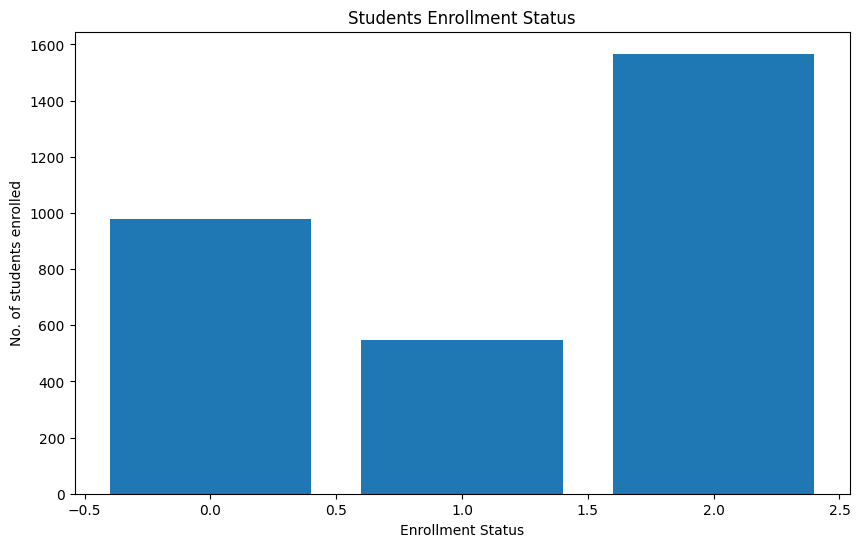

In [ ]:
fig = plt.figure(figsize = (10, 5))

value_counts = train['Target'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Enrollment Status")
plt.ylabel("No. of students enrolled")
plt.title("Students Enrollment Status")
plt.show()

On the first glance, it seems that our data is unbalanced, but we will further explore it by visualizing interesting columns and see what we can find.

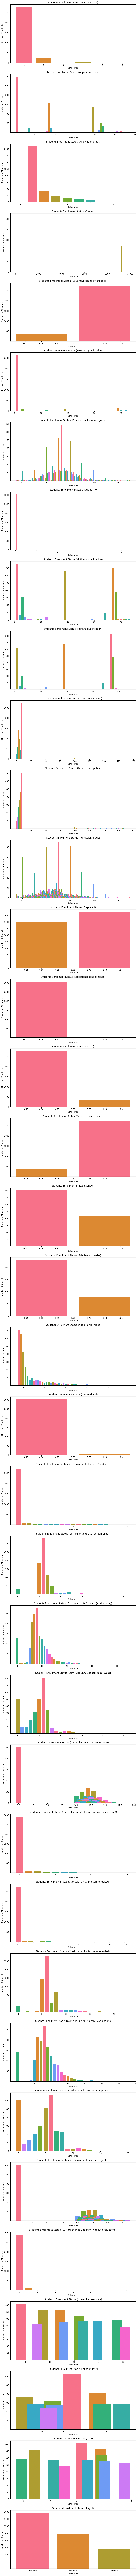

In [ ]:
train_num = pd.concat([X_train, y_train], axis=1)

columns = train_num.columns

fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5 * len(columns)))
colors = sns.color_palette("husl", 10)

for i, column in enumerate(columns):
    value_counts = train_num[column].value_counts()
    bar_colors = colors[:len(value_counts)]
    axes[i].bar(value_counts.index, value_counts.values, color=bar_colors)
    axes[i].set_xlabel("Categories")
    axes[i].set_ylabel("Number of Students")
    axes[i].set_title(f"Students Enrollment Status ({column})")

plt.tight_layout()
plt.show()

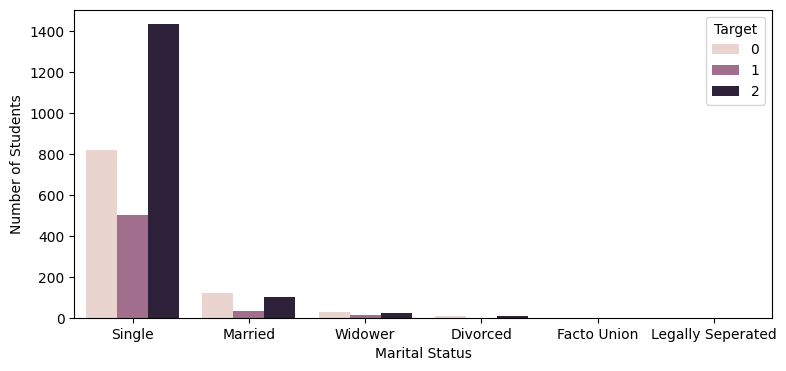

In [ ]:
plt.figure(figsize=(9,4))

sns.countplot(data=train, x='Marital status', hue='Target', hue_order=['Dropout', 'Enrolled', 'Graduate'])

plt.xticks(ticks=[0,1,2,3,4,5], labels=['Single','Married','Widower','Divorced','Facto Union','Legally Seperated'])
plt.xlabel('Marital Status')
plt.ylabel('Number of Students')
plt.show()

In [ ]:
train['Marital status'].value_counts()

Marital status
single               2755
married               256
divorced               63
facto union            17
widower                 3
legally separated       2
Name: count, dtype: int64

It looks like `Marital status` is very unbalanced. When we train our model, we might need to balance the data by sampling it. We shouldn't just remove or change the rare values because they can still occur in real life, even if they're not common.

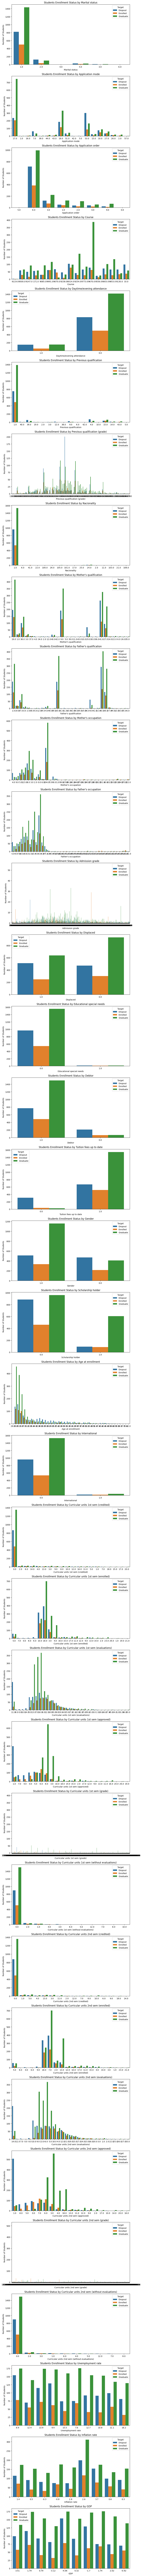

In [ ]:
columns = [col for col in train_num.columns if col not in ['Target']]

fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5 * len(columns)))

for i, column in enumerate(columns):
    sns.countplot(data=train_num, x=column, hue='Target', hue_order=['Dropout', 'Enrolled', 'Graduate'], ax=axes[i])

    unique_values = train_num[column].unique()
    axes[i].set_xticks(range(len(unique_values)))
    axes[i].set_xticklabels(unique_values)

    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Number of Students')
    axes[i].set_title(f'Students Enrollment Status by {column}')

plt.tight_layout()
plt.show()

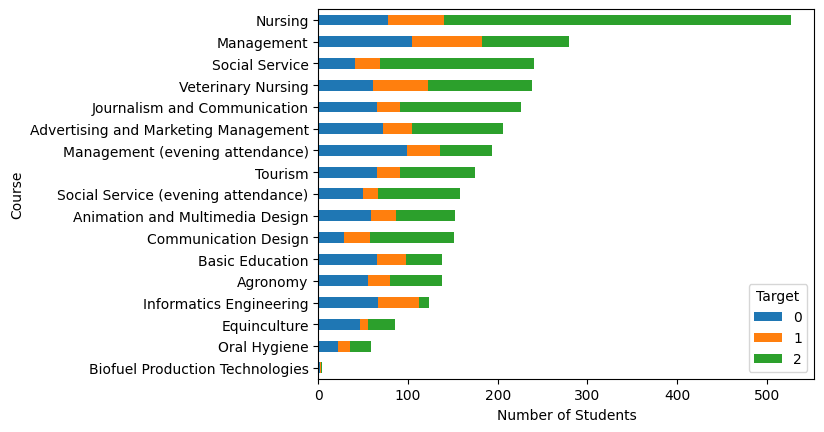

In [ ]:
course = train.groupby(['Course', 'Target']).size().reset_index().pivot(columns='Target', index='Course', values=0)

course_total = course.sum(axis=1)
course_sorted = course_total.sort_values(ascending=True)
course.loc[course_sorted.index].plot(kind='barh', stacked=True)

plt.xlabel('Number of Students')
plt.show()

`Nursing` course produced the highest number of graduates, while `Management` produced the highest number of dropouts, therefore, choosing a specific major might increase/decrease your chances of graduation.

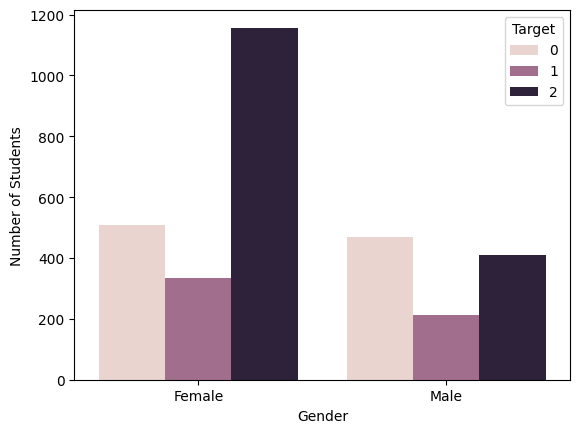

In [ ]:
sns.countplot(data=train, x='Gender', hue='Target', hue_order=['Dropout', 'Enrolled', 'Graduate'])

plt.xticks(ticks=[0,1], labels=['Female','Male'])
plt.ylabel('Number of Students')
plt.show()

In [ ]:
train['Gender'].value_counts()

Gender
0.0    2002
1.0    1094
Name: count, dtype: int64

In [ ]:
n_males = len(train[train['Gender'] == 1.0])
n_females = len(train[train['Gender'] == 0.0])

for label, label_name in zip([0, 1, 2], ['Dropout', 'Enrolled', 'Graduate']):
    males = len(train[(train['Gender'] == 1.0) & (train['Target'] == label)])
    females = len(train[(train['Gender'] == 0.0) & (train['Target'] == label)])

    male_percentage = (males / n_males) * 100 if n_males > 0 else 0
    female_percentage = (females / n_females) * 100 if n_females > 0 else 0

    print(f'Percentage of males who are {label_name}: {male_percentage:.2f}%')
    print(f'Percentage of females who are {label_name}: {female_percentage:.2f}%')


Percentage of males who are Dropout: 42.96%
Percentage of females who are Dropout: 25.47%
Percentage of males who are Enrolled: 19.56%
Percentage of females who are Enrolled: 16.73%
Percentage of males who are Graduate: 37.48%
Percentage of females who are Graduate: 57.79%


In terms of proportions, the number of females and males who are either graduates or currently enrolled students is nearly equal, with females having a slight edge. Even though the data shows a higher presence of females and the dropout numbers for both genders are almost identical, it is observed that males have a higher likelihood of dropping out when compared proportionally.

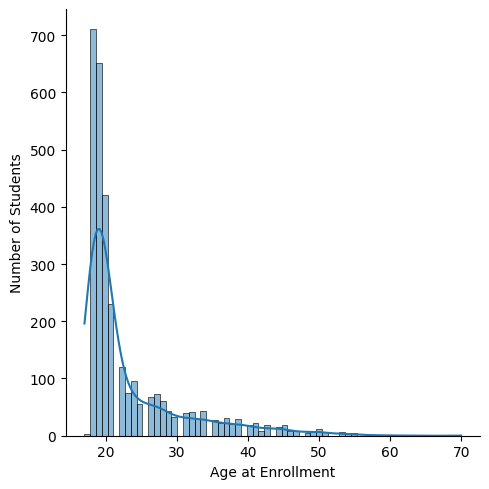

In [ ]:
sns.displot(data=train, x='Age at enrollment', kde=True)
train['Age at enrollment'].describe()

plt.xlabel('Age at Enrollment')
plt.ylabel('Number of Students')
plt.show()

`Age at enrollment` is a bit skewed to the left, and that's understandable since most people attend college in their 20s. However we will try to prevent this from affecting our model later on when we process outliers.

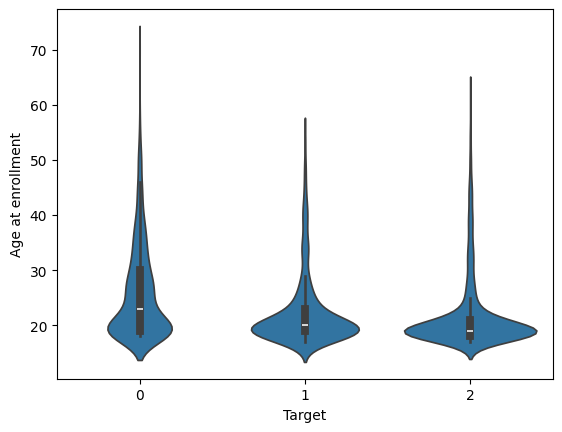

In [ ]:
sns.violinplot(x='Target', y='Age at enrollment', data=train)
plt.show()

It seems that the `Age at enrollment` doesn't correlate that much with `Target`.

## Data Analysis

### Previous qualification & Previous qualification (grade)

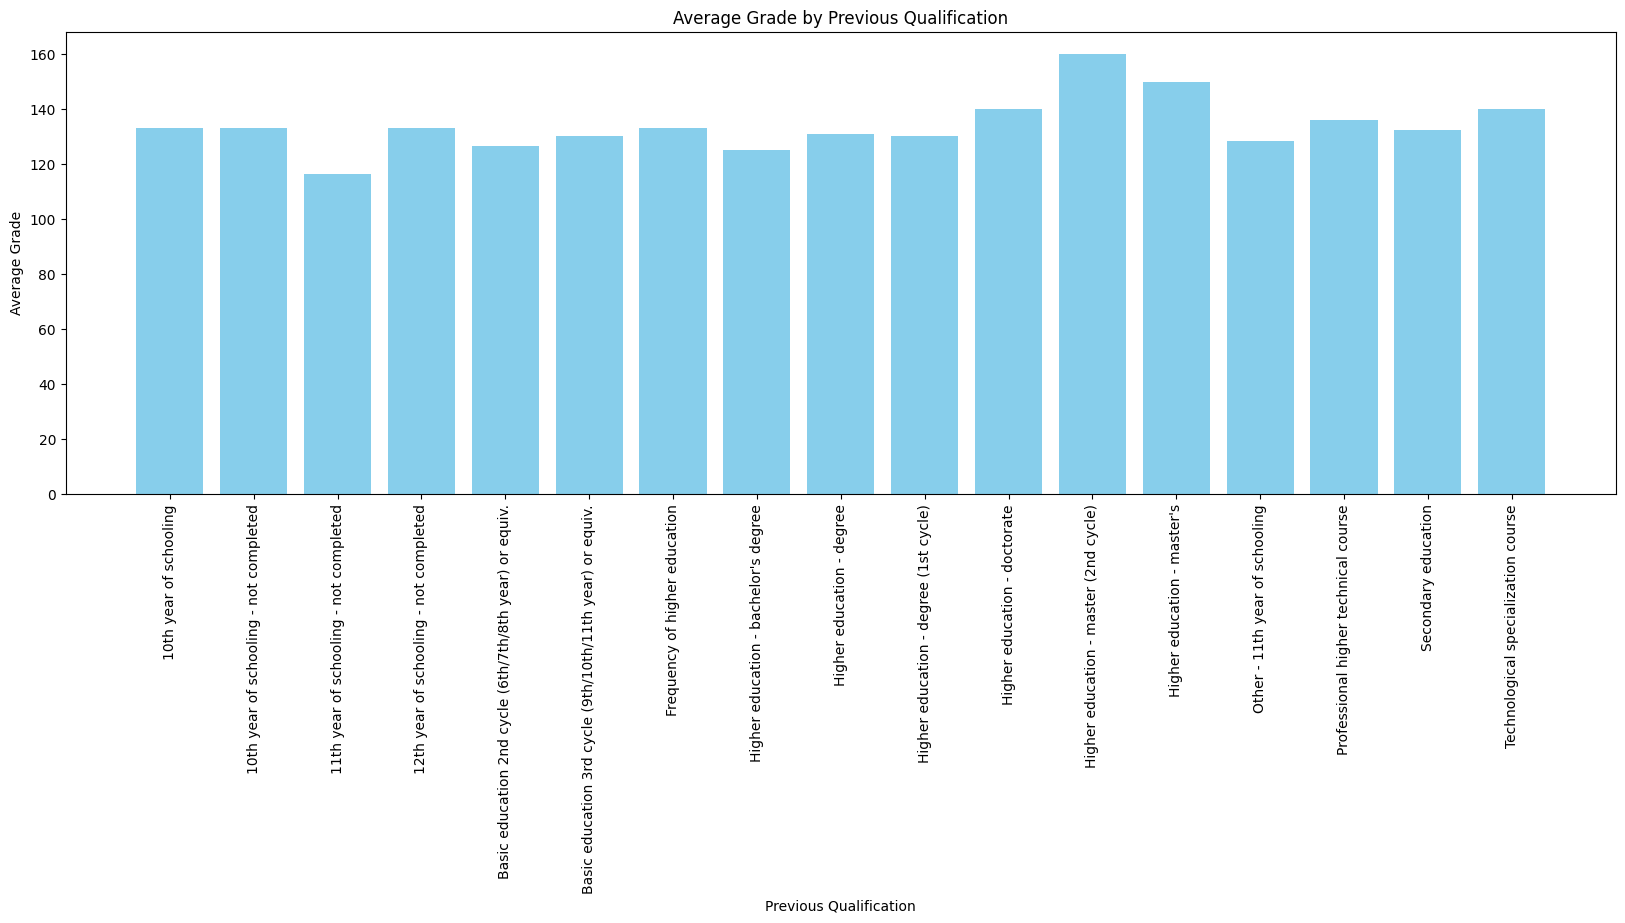

In [ ]:
train = pd.concat([X_train_transformed, y_train_transformed], axis=1)


average_grades = train.groupby('Previous qualification')['Previous qualification (grade)'].mean()

plt.figure(figsize=(20, 6))
plt.bar(average_grades.index, average_grades.values, color='skyblue')
plt.xlabel('Previous Qualification')
plt.ylabel('Average Grade')
plt.title('Average Grade by Previous Qualification')
plt.xticks(rotation=90)
plt.show()

#from the table that students with advanced educational qualifications, such as a master's degree (2nd cycle),
#achieve the highest average grades, while students who did not complete the 11th year of schooling have the lowest average grades.

In [ ]:
grades_stats = train.groupby('Previous qualification')['Previous qualification (grade)'].agg(
    average='mean',
    min_grade='min',
    max_grade='max',
    mode_grade=lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
    count='size'
)

grades_stats


#The "Secondary education" category contains the largest number of students (2636), making the average grade for this category more reliable.
#In contrast, categories such as "Higher education - master(2nd cycle)" contain very few students (3), making the average grade for this category less reliable.

average  min_grade  \
Previous qualification                                                      
10th year of schooling                              133.100000      133.1   
10th year of schooling - not completed              133.100000      133.1   
11th year of schooling - not completed              116.550000      100.0   
12th year of schooling - not completed              133.100000      133.1   
Basic education 2nd cycle (6th/7th/8th year) or...  126.480000      100.0   
Basic education 3rd cycle (9th/10th/11th year) ...  130.152294      100.0   
Frequency of higher education                       133.060000      118.9   
Higher education - bachelor's degree                125.221429      100.0   
Higher education - degree                           131.163855      105.0   
Higher education - degree (1st cycle)               130.390323      110.0   
Higher education - doctorate                        140.000000      140.0   
Higher education - master (2nd cycle)               160.000000      140.0   
Higher education - master's                         150.000000      120.0   
Other - 11th year of schooling                      128.573529      100.0   
Professional higher technical course                136.153846      110.0   
Secondary education                                 132.311538       95.0   
Technological specialization course                 139.934586      100.0   

                                                    max_grade  mode_grade  \
Previous qualification                                                      
10th year of schooling                                  133.1       133.1   
10th year of schooling - not completed                  133.1       133.1   
11th year of schooling - not completed                  133.1       100.0   
12th year of schooling - not completed                  133.1       133.1   
Basic education 2nd cycle (6th/7th/8th year) or...      133.1       133.1   
Basic education 3rd cycle (9th/10th/11th year) ...      149.0       133.1   
Frequency of higher education                           170.0       120.0   
Higher education - bachelor's degree                    140.0       120.0   
Higher education - degree                               170.0       130.0   
Higher education - degree (1st cycle)                   150.0       130.0   
Higher education - doctorate                            140.0       140.0   
Higher education - master (2nd cycle)                   180.0       140.0   
Higher education - master's                             190.0       120.0   
Other - 11th year of schooling                          170.0       133.1   
Professional higher technical course                    160.0       140.0   
Secondary education                                     190.0       133.1   
Technological specialization course                     180.0       140.0   

                                                    count  
Previous qualification                                     
10th year of schooling                                  1  
10th year of schooling - not completed                  1  
11th year of schooling - not completed                  2  
12th year of schooling - not completed                 10  
Basic education 2nd cycle (6th/7th/8th year) or...      5  
Basic education 3rd cycle (9th/10th/11th year) ...    109  
Frequency of higher education                          10  
Higher education - bachelor's degree                   14  
Higher education - degree                              83  
Higher education - degree (1st cycle)                  31  
Higher education - doctorate                            1  
Higher education - master (2nd cycle)                   3  
Higher education - master's                             7  
Other - 11th year of schooling                         34  
Professional higher technical course                   26  
Secondary education                                  2626  
Technological specialization course            

### Average Grade

<Figure size 2000x600 with 0 Axes>

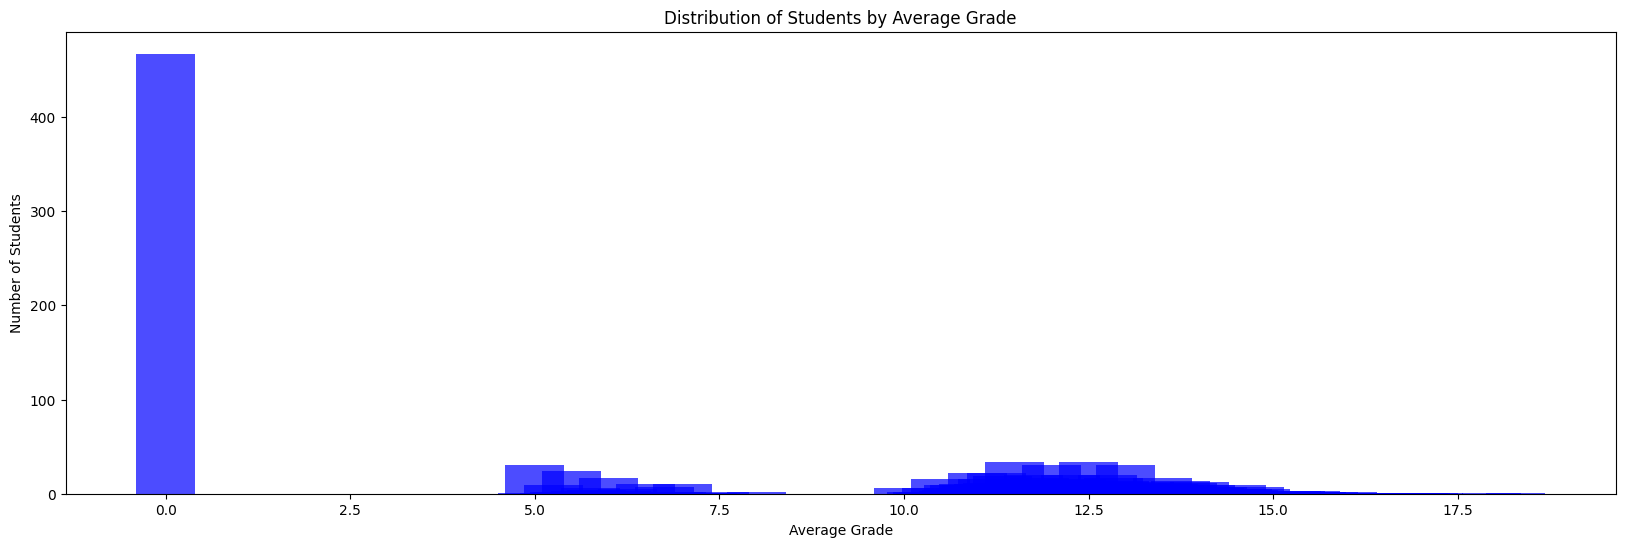

In [ ]:
plt.figure(figsize=(20, 6))

train['Average Grade'] = train[['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']].mean(axis=1)

grade_counts = train['Average Grade'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(grade_counts.index, grade_counts.values, color='blue', alpha=0.7, label='Number of Students')

ax.set_xlabel('Average Grade')
ax.set_ylabel('Number of Students')
ax.set_title('Distribution of Students by Average Grade')
plt.show()

# from the plot that a very large number of students have an average grade of zero, while the rest of the grades are distributed among a smaller number of students.
# This suggests that a significant number of students may have issues passing their courses.

In [ ]:
average_grade_stats = {
    'Mean': train['Average Grade'].mean(),
    'Max': train['Average Grade'].max(),
    'Min': train['Average Grade'].min(),
    'Most Frequent': grade_counts.idxmax(),
    'Count 0-5': len(train[(train['Average Grade'] >= 0) & (train['Average Grade'] < 5)]),
    'Count 5-10': len(train[(train['Average Grade'] >= 5) & (train['Average Grade'] <= 10)]),
    'Count 10-15': len(train[(train['Average Grade'] >= 10) & (train['Average Grade'] < 15)]),
    'Count 15-20': len(train[(train['Average Grade'] >= 15) & (train['Average Grade'] <= 20)])
}

stats_df = pd.DataFrame.from_dict(average_grade_stats, orient='index', columns=['Value'])
stats_df


#the average grade is 10.45, and the most frequent grade is 0, suggesting that a large number of students are struggling to pass their courses.
#The majority of students have grades between 10 and 15.

Value
Mean             10.451034
Max              18.283654
Min               0.000000
Most Frequent     0.000000
Count 0-5       468.000000
Count 5-10      175.000000
Count 10-15    2354.000000
Count 15-20     105.000000

In [ ]:
grade_counts = train['Average Grade'].value_counts()

grade_counts_sorted = grade_counts.sort_values(ascending=False)

grade_counts_df = grade_counts_sorted.reset_index()
grade_counts_df.columns = ['Average Grade', 'Number of Students']

grade_counts_df.head(15)

#frequent grade

Average Grade  Number of Students
0        0.000000                 467
1       11.500000                  34
2       12.500000                  34
3        5.000000                  31
4       13.000000                  31
5       12.000000                  31
6        5.500000                  24
7       11.250000                  22
8       11.000000                  22
9       11.750000                  20
10      12.750000                  20
11      12.250000                  20
12      11.333333                  19
13      11.833333                  17
14      12.833333                  17

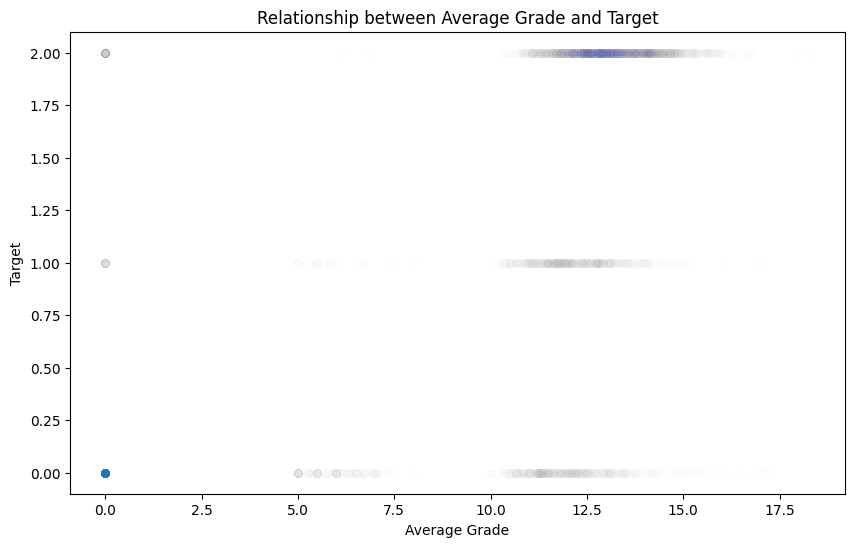

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train['Average Grade'], train['Target'], alpha=0.005)
plt.title('Relationship between Average Grade and Target')
plt.xlabel('Average Grade')
plt.ylabel('Target')
plt.show()

#the relationship between average grades and the academic status of students (Dropout, Enrolled, Graduate),  ['Dropout', 'Enrolled', 'Graduate'] 0,1,2
#The dark points indicate a strong relationship, while the light points indicate a weak relationship.
#It can be observed that students with an average grade of zero tend to drop out, while students with higher average grades (between 10 and 15) tend to graduate.

### Mother's qualification & Father's qualification

In [ ]:
combined_counts_mother = train.groupby(['Mother\'s qualification', 'Average Grade']).size().reset_index(name='Number of Students')

sorted_combined_counts_mother = combined_counts_mother.sort_values(by='Average Grade')
sorted_combined_counts_mother[sorted_combined_counts_mother['Number of Students']>10].head(30)

#The biggest impact on zero scores comes from students whose mothers' qualifications are at basic or unknown levels.

Mother's qualification  Average Grade  \
283   Basic Education 3rd Cycle (9th/10th/11th Year)...            0.0   
16    Basic Education 2nd Cycle (6th/7th/8th Year) o...            0.0   
1101                          Higher Education - Degree            0.0   
663   Basic education 1st cycle (4th/5th year) or eq...            0.0   
1884                                            Unknown            0.0   
1406  Secondary Education - 12th Year of Schooling o...            0.0   
1481  Secondary Education - 12th Year of Schooling o...           11.5   
839   Basic education 1st cycle (4th/5th year) or eq...           12.5   

      Number of Students  
283                  102  
16                    36  
1101                  54  
663                  121  
1884                  35  
1406                  89  
1481                  11  
839                   11

In [ ]:
sorted_combined_counts_mother[sorted_combined_counts_mother['Average Grade']>17].head(30)

Mother's qualification  Average Grade  \
661   Basic Education 3rd Cycle (9th/10th/11th Year)...      17.107143   
1047  Basic education 1st cycle (4th/5th year) or eq...      17.166667   
662   Basic Education 3rd Cycle (9th/10th/11th Year)...      17.952381   
1320                          Higher Education - Degree      18.283654   

      Number of Students  
661                    1  
1047                   1  
662                    1  
1320                   1

In [ ]:
combined_counts_father = train.groupby(["Father's qualification", 'Average Grade']).size().reset_index(name='Number of Students')

sorted_combined_counts_father = combined_counts_father.sort_values(by='Average Grade')
sorted_combined_counts_father[sorted_combined_counts_father['Number of Students']>10].head(30)

#The biggest impact on zero scores comes from students whose Father's qualifications are at basic or unknown levels.

Father's qualification  Average Grade  \
334   Basic Education 3rd Cycle (9th/10th/11th Year)...            0.0   
23    Basic Education 2nd Cycle (6th/7th/8th Year) o...            0.0   
752   Basic education 1st cycle (4th/5th year) or eq...            0.0   
1260                          Higher Education - Degree            0.0   
1480  Secondary Education - 12th Year of Schooling o...            0.0   
1882                                            Unknown            0.0   
832   Basic education 1st cycle (4th/5th year) or eq...           11.5   
943   Basic education 1st cycle (4th/5th year) or eq...           12.5   
1007  Basic education 1st cycle (4th/5th year) or eq...           13.0   

      Number of Students  
334                   96  
23                    47  
752                  136  
1260                  28  
1480                  89  
1882                  31  
832                   13  
943                   11  
1007                  12

In [ ]:
sorted_combined_counts_father[sorted_combined_counts_father['Average Grade']>17].head(30)

Father's qualification  Average Grade  \
1204  Basic education 1st cycle (4th/5th year) or eq...      17.107143   
333   Basic Education 2nd Cycle (6th/7th/8th Year) o...      17.166667   
750   Basic Education 3rd Cycle (9th/10th/11th Year)...      17.952381   
751   Basic Education 3rd Cycle (9th/10th/11th Year)...      18.283654   

      Number of Students  
1204                   1  
333                    1  
750                    1  
751                    1

In [ ]:
combined_counts_m_f = train.groupby(['Mother\'s qualification', "Father's qualification", 'Average Grade' ]).size().reset_index(name='Number of Students')

sorted_combined_counts_m_f = combined_counts_m_f.sort_values(by='Average Grade')
sorted_combined_counts_m_f[sorted_combined_counts_m_f['Number of Students']>10].head(30)

#The "Basic education 1st cycle (4th/5th year) or equivalent" has the most significant impact on the student's grade (zero).

Mother's qualification  \
1528                          Higher Education - Degree   
944   Basic education 1st cycle (4th/5th year) or eq...   
1770  Secondary Education - 12th Year of Schooling o...   
611   Basic Education 3rd Cycle (9th/10th/11th Year)...   
747   Basic Education 3rd Cycle (9th/10th/11th Year)...   
2065  Secondary Education - 12th Year of Schooling o...   
1697  Secondary Education - 12th Year of Schooling o...   
1437                          Higher Education - Degree   
441   Basic Education 3rd Cycle (9th/10th/11th Year)...   
333   Basic Education 3rd Cycle (9th/10th/11th Year)...   
197   Basic Education 2nd Cycle (6th/7th/8th Year) o...   
2310                                            Unknown   

                                 Father's qualification  Average Grade  \
1528  Secondary Education - 12th Year of Schooling o...            0.0   
944   Basic education 1st cycle (4th/5th year) or eq...            0.0   
1770  Basic Education 3rd Cycle (9th/10th/11th Year)...            0.0   
611   Basic education 1st cycle (4th/5th year) or eq...            0.0   
747   Secondary Education - 12th Year of Schooling o...            0.0   
2065  Secondary Education - 12th Year of Schooling o...            0.0   
1697  Basic Education 2nd Cycle (6th/7th/8th Year) o...            0.0   
1437                          Higher Education - Degree            0.0   
441   Basic Education 3rd Cycle (9th/10th/11th Year)...            0.0   
333   Basic Education 2nd Cycle (6th/7th/8th Year) o...            0.0   
197   Basic education 1st cycle (4th/5th year) or eq...            0.0   
2310                                            Unknown            0.0   

      Number of Students  
1528                  19  
944                   94  
1770                  20  
611                   16  
747                   25  
2065                  32  
1697                  11  
1437                  12  
441                   40  
333                   15  
197                   12  
2310                  29

In [ ]:
sorted_combined_counts_m_f[(sorted_combined_counts_m_f['Number of Students'] > 10) &
    (sorted_combined_counts_m_f['Mother\'s qualification'].isin(sorted_combined_counts_mother[sorted_combined_counts_mother['Number of Students'] > 10]['Mother\'s qualification'].head(30))) &
    (sorted_combined_counts_m_f["Father's qualification"].isin(sorted_combined_counts_father[sorted_combined_counts_father['Number of Students'] > 10]["Father's qualification"].head(30)))
    ].head(30)

#The "Basic education 1st cycle (4th/5th year) or equivalent" has the most significant impact on the student's grade (zero).

Mother's qualification  \
1528                          Higher Education - Degree   
944   Basic education 1st cycle (4th/5th year) or eq...   
1770  Secondary Education - 12th Year of Schooling o...   
611   Basic Education 3rd Cycle (9th/10th/11th Year)...   
747   Basic Education 3rd Cycle (9th/10th/11th Year)...   
2065  Secondary Education - 12th Year of Schooling o...   
1697  Secondary Education - 12th Year of Schooling o...   
1437                          Higher Education - Degree   
441   Basic Education 3rd Cycle (9th/10th/11th Year)...   
333   Basic Education 3rd Cycle (9th/10th/11th Year)...   
197   Basic Education 2nd Cycle (6th/7th/8th Year) o...   
2310                                            Unknown   

                                 Father's qualification  Average Grade  \
1528  Secondary Education - 12th Year of Schooling o...            0.0   
944   Basic education 1st cycle (4th/5th year) or eq...            0.0   
1770  Basic Education 3rd Cycle (9th/10th/11th Year)...            0.0   
611   Basic education 1st cycle (4th/5th year) or eq...            0.0   
747   Secondary Education - 12th Year of Schooling o...            0.0   
2065  Secondary Education - 12th Year of Schooling o...            0.0   
1697  Basic Education 2nd Cycle (6th/7th/8th Year) o...            0.0   
1437                          Higher Education - Degree            0.0   
441   Basic Education 3rd Cycle (9th/10th/11th Year)...            0.0   
333   Basic Education 2nd Cycle (6th/7th/8th Year) o...            0.0   
197   Basic education 1st cycle (4th/5th year) or eq...            0.0   
2310                                            Unknown            0.0   

      Number of Students  
1528                  19  
944                   94  
1770                  20  
611                   16  
747                   25  
2065                  32  
1697                  11  
1437                  12  
441                   40  
333                   15  
197                   12  
2310                  29

In [ ]:
sorted_combined_counts_m_f[(sorted_combined_counts_m_f['Average Grade']>17) &
    (sorted_combined_counts_m_f['Mother\'s qualification'].isin(sorted_combined_counts_mother[sorted_combined_counts_mother['Average Grade']>17]['Mother\'s qualification'].head(30))) &
    (sorted_combined_counts_m_f["Father's qualification"].isin(sorted_combined_counts_father[sorted_combined_counts_father['Average Grade']>17]["Father's qualification"].head(30)))
    ].head(30)

Mother's qualification  \
718   Basic Education 3rd Cycle (9th/10th/11th Year)...   
897   Basic education 1st cycle (4th/5th year) or eq...   
610   Basic Education 3rd Cycle (9th/10th/11th Year)...   
1412                          Higher Education - Degree   

                                 Father's qualification  Average Grade  \
718   Basic education 1st cycle (4th/5th year) or eq...      17.107143   
897   Basic Education 2nd Cycle (6th/7th/8th Year) o...      17.166667   
610   Basic Education 3rd Cycle (9th/10th/11th Year)...      17.952381   
1412  Basic Education 3rd Cycle (9th/10th/11th Year)...      18.283654   

      Number of Students  
718                    1  
897                    1  
610                    1  
1412                   1

### Mother's occupation & Father's occupation

In [ ]:
combined_counts_mother_occupation = train.groupby(['Mother\'s occupation', 'Average Grade']).size().reset_index(name='Number of Students')

sorted_combined_counts_mother_occupation = combined_counts_mother_occupation.sort_values(by='Average Grade')

sorted_combined_counts_mother_occupation[sorted_combined_counts_mother_occupation['Number of Students'] > 10].head(30)

#We conclude that unskilled jobs and intellectual and scientific jobs for mothers significantly impact students receiving zero grades.
#Additionally, there is a noticeable effect on students whose mothers are in security and service jobs, as well as those whose mothers are in administrative positions , Students .



Mother's occupation  Average Grade  \
1143  Specialists in Intellectual and Scientific Act...            0.0   
677   Personal Services, Security and Safety Workers...            0.0   
1000  Skilled Workers in Industry, Construction and ...            0.0   
645                                     Other Situation            0.0   
1375                                  Unskilled Workers            0.0   
434      Intermediate Level Technicians and Professions            0.0   
1317                                            Student            0.0   
9                                  Administrative staff            0.0   
1465                                  Unskilled Workers           11.5   
1527                                  Unskilled Workers           12.0   
1607                                  Unskilled Workers           12.5   
1690                                  Unskilled Workers           13.0   

      Number of Students  
1143                  38  
677                   46  
1000                  28  
645                   17  
1375                 165  
434                   30  
1317                  34  
9                     74  
1465                  13  
1527                  13  
1607                  13  
1690                  17

In [ ]:
sorted_combined_counts_mother_occupation[sorted_combined_counts_mother_occupation['Average Grade'] > 17].head(30)

Mother's occupation  Average Grade  \
1945                                  Unskilled Workers      17.107143   
939   Personal Services, Security and Safety Workers...      17.166667   
361                                Administrative staff      17.952381   
362                                Administrative staff      18.283654   

      Number of Students  
1945                   1  
939                    1  
361                    1  
362                    1

In [ ]:
combined_counts_father_occupation = train.groupby(["Father's occupation", 'Average Grade']).size().reset_index(name='Number of Students')

sorted_combined_counts_father_occupation = combined_counts_father_occupation.sort_values(by='Average Grade')

sorted_combined_counts_father_occupation[sorted_combined_counts_father_occupation['Number of Students'] > 10].head(30)

#We find that unskilled, security and service, and administrative jobs for both mothers and fathers significantly impact students receiving zero grades.
#The impact of mothers in intellectual and scientific jobs is more pronounced compared to fathers,
#whereas the influence of fathers in industry, construction, and military jobs is more evident compared to mothers.



Father's occupation  Average Grade  \
1197  Skilled Workers in Industry, Construction and ...            0.0   
1625                                            Student            0.0   
1120  Representatives of the Legislative Power and E...            0.0   
1688                                  Unskilled Workers            0.0   
880   Personal Services, Security and Safety Workers...            0.0   
843                                     Other Situation            0.0   
632      Intermediate Level Technicians and Professions            0.0   
1519  Specialists in Intellectual and Scientific Act...            0.0   
9                                  Administrative staff            0.0   
352   Farmers and Skilled Workers in Agriculture, Fi...            0.0   
473   Installation and Machine Operators and Assembl...            0.0   
208                            Armed Forces Professions            0.0   
1903                                  Unskilled Workers           13.0   

      Number of Students  
1197                  59  
1625                  27  
1120                  18  
1688                 107  
880                   54  
843                   15  
632                   38  
1519                  25  
9                     26  
352                   24  
473                   32  
208                   30  
1903                  11

In [ ]:
sorted_combined_counts_father_occupation[sorted_combined_counts_father_occupation['Average Grade'] > 17].head(30)

Father's occupation  Average Grade  \
2074                                  Unskilled Workers      17.107143   
1510  Skilled Workers in Industry, Construction and ...      17.166667   
207                                Administrative staff      17.952381   
458   Farmers and Skilled Workers in Agriculture, Fi...      18.283654   

      Number of Students  
2074                   1  
1510                   1  
207                    1  
458                    1

In [ ]:
combined_counts_parents_occupation = train.groupby(['Mother\'s occupation', "Father's occupation", 'Average Grade']).size().reset_index(name='Number of Students')

sorted_combined_counts_parents_occupation = combined_counts_parents_occupation.sort_values(by='Average Grade')

sorted_combined_counts_parents_occupation[sorted_combined_counts_parents_occupation['Number of Students'] > 10].head(30)

#The "Unskilled Workers" has the most significant impact on the student's grade (zero).

Mother's occupation  \
1533  Specialists in Intellectual and Scientific Act...   
312                                Administrative staff   
2021                                  Unskilled Workers   
1947                                  Unskilled Workers   
1313  Skilled Workers in Industry, Construction and ...   
1829                                  Unskilled Workers   
1740                                  Unskilled Workers   
1635                                            Student   
2163                                  Unskilled Workers   
624      Intermediate Level Technicians and Professions   
816                                     Other Situation   
964   Personal Services, Security and Safety Workers...   
9                                  Administrative staff   
2335                                  Unskilled Workers   

                                    Father's occupation  Average Grade  \
1533  Specialists in Intellectual and Scientific Act...            0.0   
312   Skilled Workers in Industry, Construction and ...            0.0   
2021  Skilled Workers in Industry, Construction and ...            0.0   
1947  Personal Services, Security and Safety Workers...            0.0   
1313  Skilled Workers in Industry, Construction and ...            0.0   
1829  Installation and Machine Operators and Assembl...            0.0   
1740                           Armed Forces Professions            0.0   
1635                                            Student            0.0   
2163                                  Unskilled Workers            0.0   
624      Intermediate Level Technicians and Professions            0.0   
816                                     Other Situation            0.0   
964   Personal Services, Security and Safety Workers...            0.0   
9                                  Administrative staff            0.0   
2335                                  Unskilled Workers           13.0   

      Number of Students  
1533                  11  
312                   14  
2021                  14  
1947                  16  
1313                  15  
1829                  15  
1740                  12  
1635                  25  
2163                  83  
624                   12  
816                   12  
964                   15  
9                     11  
2335                  11

In [ ]:
sorted_combined_counts_parents_occupation[sorted_combined_counts_parents_occupation['Average Grade'] > 17].head(30)

Mother's occupation  \
2461                                  Unskilled Workers   
1145  Personal Services, Security and Safety Workers...   
100                                Administrative staff   
158                                Administrative staff   

                                    Father's occupation  Average Grade  \
2461                                  Unskilled Workers      17.107143   
1145  Skilled Workers in Industry, Construction and ...      17.166667   
100                                Administrative staff      17.952381   
158   Farmers and Skilled Workers in Agriculture, Fi...      18.283654   

      Number of Students  
2461                   1  
1145                   1  
100                    1  
158                    1

In [ ]:
sorted_combined_counts_parents_occupation[
    (sorted_combined_counts_parents_occupation['Number of Students'] > 10) &
    (sorted_combined_counts_parents_occupation['Mother\'s occupation'].isin(sorted_combined_counts_mother_occupation[sorted_combined_counts_mother_occupation['Number of Students'] > 10]['Mother\'s occupation'].head(30))) &
    (sorted_combined_counts_parents_occupation["Father's occupation"].isin(sorted_combined_counts_father_occupation[sorted_combined_counts_father_occupation['Number of Students'] > 10]["Father's occupation"].head(30)))
].head(30)


#The "Unskilled Workers" has the most significant impact on the student's grade (zero).

Mother's occupation  \
1533  Specialists in Intellectual and Scientific Act...   
312                                Administrative staff   
2021                                  Unskilled Workers   
1947                                  Unskilled Workers   
1313  Skilled Workers in Industry, Construction and ...   
1829                                  Unskilled Workers   
1740                                  Unskilled Workers   
1635                                            Student   
2163                                  Unskilled Workers   
624      Intermediate Level Technicians and Professions   
816                                     Other Situation   
964   Personal Services, Security and Safety Workers...   
9                                  Administrative staff   
2335                                  Unskilled Workers   

                                    Father's occupation  Average Grade  \
1533  Specialists in Intellectual and Scientific Act...            0.0   
312   Skilled Workers in Industry, Construction and ...            0.0   
2021  Skilled Workers in Industry, Construction and ...            0.0   
1947  Personal Services, Security and Safety Workers...            0.0   
1313  Skilled Workers in Industry, Construction and ...            0.0   
1829  Installation and Machine Operators and Assembl...            0.0   
1740                           Armed Forces Professions            0.0   
1635                                            Student            0.0   
2163                                  Unskilled Workers            0.0   
624      Intermediate Level Technicians and Professions            0.0   
816                                     Other Situation            0.0   
964   Personal Services, Security and Safety Workers...            0.0   
9                                  Administrative staff            0.0   
2335                                  Unskilled Workers           13.0   

      Number of Students  
1533                  11  
312                   14  
2021                  14  
1947                  16  
1313                  15  
1829                  15  
1740                  12  
1635                  25  
2163                  83  
624                   12  
816                   12  
964                   15  
9                     11  
2335                  11

In [ ]:
sorted_combined_counts_parents_occupation[
    (sorted_combined_counts_parents_occupation['Average Grade'] > 17) &
    (sorted_combined_counts_parents_occupation['Mother\'s occupation'].isin(sorted_combined_counts_mother_occupation[sorted_combined_counts_mother_occupation['Average Grade'] > 17]['Mother\'s occupation'].head(30))) &
    (sorted_combined_counts_parents_occupation["Father's occupation"].isin(sorted_combined_counts_father_occupation[sorted_combined_counts_father_occupation['Average Grade'] > 17]["Father's occupation"].head(30)))
].head(30)

Mother's occupation  \
2461                                  Unskilled Workers   
1145  Personal Services, Security and Safety Workers...   
100                                Administrative staff   
158                                Administrative staff   

                                    Father's occupation  Average Grade  \
2461                                  Unskilled Workers      17.107143   
1145  Skilled Workers in Industry, Construction and ...      17.166667   
100                                Administrative staff      17.952381   
158   Farmers and Skilled Workers in Agriculture, Fi...      18.283654   

      Number of Students  
2461                   1  
1145                   1  
100                    1  
158                    1

### Curricular units 1st

In [ ]:
combined_counts_1st_sem = train.groupby([
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (without evaluations)' ,
    'Curricular units 1st sem (grade)'

]).size().reset_index(name='Number of Students')

sorted_combined_counts_1st_sem = combined_counts_1st_sem.sort_values(by='Curricular units 1st sem (grade)', ascending=False)

sorted_combined_counts_1st_sem[sorted_combined_counts_1st_sem['Number of Students'] > 10].head(30)

#We noticed that students who enrolled in 6 curricular units in approved the first semester and received credit for all of them achieved high grades ranging between 12 and 14.

Curricular units 1st sem (credited)  Curricular units 1st sem (enrolled)  \
470                                  0.0                                  6.0   
469                                  0.0                                  6.0   
467                                  0.0                                  6.0   
466                                  0.0                                  6.0   
465                                  0.0                                  6.0   
464                                  0.0                                  6.0   
463                                  0.0                                  6.0   
462                                  0.0                                  6.0   
461                                  0.0                                  6.0   
459                                  0.0                                  6.0   
16                                   0.0                                  5.0   
17                                   0.0                                  5.0   
59                                   0.0                                  5.0   
281                                  0.0                                  5.0   
867                                  0.0                                  6.0   
486                                  0.0                                  6.0   
427                                  0.0                                  6.0   
426                                  0.0                                  6.0   
989                                  0.0                                  7.0   
0                                    0.0                                  0.0   

     Curricular units 1st sem (evaluations)  \
470                                     6.0   
469                                     6.0   
467                                     6.0   
466                                     6.0   
465                                     6.0   
464                                     6.0   
463                                     6.0   
462                                     6.0   
461                                     6.0   
459                                     6.0   
16                                      0.0   
17                                      5.0   
59                                      6.0   
281                                    10.0   
867                                    12.0   
486                                     7.0   
427                                     6.0   
426                                     0.0   
989                                     0.0   
0                                       0.0   

     Curricular units 1st sem (approved)  \
470                                  6.0   
469                                  6.0   
467                                  6.0   
466                                  6.0   
465                                  6.0   
464                                  6.0   
463                                  6.0   
462                                  6.0   
461                                  6.0   
459                                  6.0   
16                                   0.0   
17                                   0.0   
59                                   0.0   
281                                  0.0   
867                                  0.0   
486                                  0.0   
427                                  0.0   
426                                  0.0   
989                                  0.0   
0                                    0.0   

     Curricular units 1st sem (without evaluations)  \
470                                             0.0   
469                                             0.0   
467                                             0.0   
466                                             0.0   
465                                             0.0   
464                                             0.0   
463  

In [ ]:
sorted_combined_counts_1st_sem[sorted_combined_counts_1st_sem['Curricular units 1st sem (grade)'] > 17].head(30)

Curricular units 1st sem (credited)  Curricular units 1st sem (enrolled)  \
682                                  0.0                                  6.0   
103                                  0.0                                  5.0   
303                                  0.0                                  5.0   

     Curricular units 1st sem (evaluations)  \
682                                     8.0   
103                                     6.0   
303                                    10.0   

     Curricular units 1st sem (approved)  \
682                                  6.0   
103                                  5.0   
303                                  3.0   

     Curricular units 1st sem (without evaluations)  \
682                                             0.0   
103                                             0.0   
303                                             0.0   

     Curricular units 1st sem (grade)  Number of Students  
682                         18.875000                   1  
103                         17.333333                   1  
303                         17.333333                   1

In [ ]:
correlation_matrix = train[[
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 1st sem (grade)'
]].corr()

correlation_matrix['Curricular units 1st sem (grade)']

#The result shows that the highest positive correlation for 2nd semester grades is with approved units 0.702 and the lowest correlation is with units without evaluations -0.062

Curricular units 1st sem (credited)               0.125799
Curricular units 1st sem (enrolled)               0.388023
Curricular units 1st sem (evaluations)            0.419394
Curricular units 1st sem (approved)               0.702624
Curricular units 1st sem (without evaluations)   -0.062630
Curricular units 1st sem (grade)                  1.000000
Name: Curricular units 1st sem (grade), dtype: float64

### Curricular units 2nd

In [ ]:
combined_counts_2nd_sem = train.groupby([
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (without evaluations)' ,
    'Curricular units 2nd sem (grade)'

]).size().reset_index(name='Number of Students')

sorted_combined_counts_2nd_sem = combined_counts_2nd_sem.sort_values(by='Curricular units 2nd sem (grade)', ascending=False)

sorted_combined_counts_2nd_sem[sorted_combined_counts_2nd_sem['Number of Students'] > 10].head(30)

#We noticed that students who enrolled in 6 curricular units in approved the Second semester and received credit for all of them achieved high grades ranging between 12 and 14.

Curricular units 2nd sem (credited)  \
485                                   0.0   
482                                   0.0   
481                                   0.0   
480                                   0.0   
479                                   0.0   
478                                   0.0   
477                                   0.0   
476                                   0.0   
475                                   0.0   
473                                   0.0   
16                                    0.0   
1148                                  0.0   
15                                    0.0   
301                                   0.0   
886                                   0.0   
63                                    0.0   
501                                   0.0   
432                                   0.0   
431                                   0.0   
0                                     0.0   

      Curricular units 2nd sem (enrolled)  \
485                                   6.0   
482                                   6.0   
481                                   6.0   
480                                   6.0   
479                                   6.0   
478                                   6.0   
477                                   6.0   
476                                   6.0   
475                                   6.0   
473                                   6.0   
16                                    5.0   
1148                                  8.0   
15                                    5.0   
301                                   5.0   
886                                   6.0   
63                                    5.0   
501                                   6.0   
432                                   6.0   
431                                   6.0   
0                                     0.0   

      Curricular units 2nd sem (evaluations)  \
485                                      6.0   
482                                      6.0   
481                                      6.0   
480                                      6.0   
479                                      6.0   
478                                      6.0   
477                                      6.0   
476                                      6.0   
475                                      6.0   
473                                      6.0   
16                                       5.0   
1148                                     0.0   
15                                       0.0   
301                                     10.0   
886                                     12.0   
63                                       6.0   
501                                      7.0   
432                                      6.0   
431                                      0.0   
0                                        0.0   

      Curricular units 2nd sem (approved)  \
485                                   6.0   
482                                   6.0   
481                                   6.0   
480                                   6.0   
479                                   6.0   
478                                   6.0   
477                                   6.0   
476                                   6.0   
475                                   6.0   
473                                   6.0   
16                                    0.0   
1148                                  0.0   
15                                    0.0   
301                                   0.0   
886                                   0.0   
63                                    0.0   
501                                   0.0   
432                                   0.0   
431                                   0.0   
0                                     0.0   

      Curricular units 2nd sem (without evaluations)  \
485                                              0.0   
482                                            

In [ ]:
sorted_combined_counts_2nd_sem[sorted_combined_counts_2nd_sem['Curricular units 2nd sem (grade)'] > 17].head(30)

Curricular units 2nd sem (credited)  \
237                                   0.0   
177                                   0.0   
1818                                  6.0   
579                                   0.0   
500                                   0.0   

      Curricular units 2nd sem (enrolled)  \
237                                   5.0   
177                                   5.0   
1818                                 12.0   
579                                   6.0   
500                                   6.0   

      Curricular units 2nd sem (evaluations)  \
237                                      8.0   
177                                      7.0   
1818                                    14.0   
579                                      7.0   
500                                      6.0   

      Curricular units 2nd sem (approved)  \
237                                   5.0   
177                                   5.0   
1818                                 12.0   
579                                   6.0   
500                                   6.0   

      Curricular units 2nd sem (without evaluations)  \
237                                              0.0   
177                                              0.0   
1818                                             0.0   
579                                              0.0   
500                                              0.0   

      Curricular units 2nd sem (grade)  Number of Students  
237                          18.571429                   1  
177                          17.714286                   1  
1818                         17.692308                   1  
579                          17.428571                   1  
500                          17.166667                   1

In [ ]:
correlation_matrix = train[[
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (without evaluations)',
    'Curricular units 2nd sem (grade)'
]].corr()

correlation_matrix['Curricular units 2nd sem (grade)']

#The result shows that the highest positive correlation for 2nd semester grades is with approved units 0.764 and the lowest correlation is with units without evaluations -0.075

Curricular units 2nd sem (credited)               0.132412
Curricular units 2nd sem (enrolled)               0.405645
Curricular units 2nd sem (evaluations)            0.465340
Curricular units 2nd sem (approved)               0.764866
Curricular units 2nd sem (without evaluations)   -0.075248
Curricular units 2nd sem (grade)                  1.000000
Name: Curricular units 2nd sem (grade), dtype: float64

# Supervised

In [ ]:
X_train_high_corr = X_train.drop(low_correlation_features, axis=1)
X_test_high_corr = X_test.drop(low_correlation_features, axis=1)

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
list(le.inverse_transform([0, 1, 2]))

['Dropout', 'Enrolled', 'Graduate']

In [ ]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Logistic Regression (Base Model) f1: {f1:.2}")

Logistic Regression (Base Model) f1: 0.61


In [ ]:
lr_high_corr = LogisticRegression()

lr_high_corr.fit(X_train_high_corr, y_train)

y_pred = lr_high_corr.predict(X_test_high_corr)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Logistic Regression with High Correlated Features f1: {f1:.2}")

Logistic Regression with High Correlated Features f1: 0.71


We can see a significant improve after using the highly correlated features. Let's now try using SMOTE.

In [ ]:
lr_smote = LogisticRegression()

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

lr_smote.fit(X_train_res, y_train_res)

y_pred = lr_smote.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Logistic Regression with SMOTE f1: {f1:.2}")

Logistic Regression with SMOTE f1: 0.66


There is a significant decrease in the performance of our model so we will opt out of using resampling. We will try StandardScaler next.

In [ ]:
lr_scaler = LogisticRegression()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_scaler.fit(X_train_scaled, y_train)

y_pred = lr_scaler.predict(X_test_scaled)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Logistic Regression with StandardScaler f1: {f1:.2}")

Logistic Regression with StandardScaler f1: 0.74


In [ ]:
lr_scaler = LogisticRegression()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_high_corr)
X_test_scaled = scaler.transform(X_test_high_corr)

lr_scaler.fit(X_train_scaled, y_train)

y_pred = lr_scaler.predict(X_test_scaled)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Logistic Regression with StandardScaler and High Correlation Features f1: {f1:.2}")

Logistic Regression with StandardScaler and High Correlation Features f1: 0.75


It's even better without highly correlated features!

One last thing before we move on. We will try using PCA.

In [ ]:
n_components = 10
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)

y_pred_pca = lr_pca.predict(X_test_pca)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 with PCA: {f1:.2}")

F1 with PCA: 0.75


In [ ]:


model = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression())

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Logistic Regression with PolynomialFeatures f1: {f1:.2}")

Logistic Regression with PolynomialFeatures f1: 0.62


In [ ]:
model = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression())

model.fit(X_train_high_corr, y_train)

y_pred = model.predict(X_test_high_corr)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Logistic Regression with PolynomialFeatures and High Correlated Features f1: {f1:.2}")

Logistic Regression with PolynomialFeatures and High Correlated Features f1: 0.71


In [ ]:
classifiers = [
    ('SVM', SVC(), {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}),
    ('Random Forest', RandomForestClassifier(), {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 5, 10]}),
    ('Logistic Regression', LogisticRegression(), {'clf__C': [0.1, 1, 10]}),
    ('Ridge Classifier', RidgeClassifier(), {'clf__alpha': [0.1, 1, 10]}),
    ('Gradient Boosting', GradientBoostingClassifier(), {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 1.0]}),
    ('K-Nearest Neighbors', KNeighborsClassifier(), {'clf__n_neighbors': [3, 5, 7]}),
    ('Naive Bayes', GaussianNB(), {}),
    ('Decision Tree', DecisionTreeClassifier(), {'clf__max_depth': [None, 5, 10]}),
    ('Neural Network', MLPClassifier(), {'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)]}),
    ('AdaBoost', AdaBoostClassifier(), {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 1.0]}),
    ('XGBoost', XGBClassifier(), {'clf__n_estimators': [50, 100, 200], 'clf__learning_rate': [0.01, 0.1, 1.0]}),
    ('CatBoostClassifier', CatBoostClassifier(loss_function='MultiClass', iterations=2, verbose=False), {'clf__learning_rate': [0.01, 0.1, 1.0], 'clf__depth': [2, 5, 10]})
]

datasets = {
    'Original': (X_train, X_test),
    'High Correlation': (X_train_high_corr, X_test_high_corr)
}

## without models

In [ ]:
results_dfs = {}

for dataset_name, (train_set, test_set) in datasets.items():
    results = []

    for name, clf, param_grid in classifiers:
        pipe = Pipeline([
            ('clf', clf)
        ])

        grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')
        grid_search.fit(train_set, y_train)

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        y_pred = grid_search.predict(test_set)

        f1_test_score = f1_score(y_test, y_pred, average='weighted')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')

        results.append({'Classifier': name, 'Best Params': best_params, 'Train Score': best_score, 'Test Score': f1_test_score, 'F1 Macro': f1_macro, 'F1 Micro': f1_micro})

    results_df = pd.DataFrame(results)

    results_dfs[dataset_name] = results_df


In [ ]:
results_dfs['Original']

Classifier                                        Best Params  \
0                   SVM            {'clf__C': 10, 'clf__kernel': 'linear'}   
1         Random Forest  {'clf__max_depth': None, 'clf__n_estimators': ...   
2   Logistic Regression                                      {'clf__C': 1}   
3      Ridge Classifier                                  {'clf__alpha': 1}   
4     Gradient Boosting  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
5   K-Nearest Neighbors                            {'clf__n_neighbors': 7}   
6           Naive Bayes                                                 {}   
7         Decision Tree                              {'clf__max_depth': 5}   
8        Neural Network                 {'clf__hidden_layer_sizes': (50,)}   
9              AdaBoost  {'clf__learning_rate': 1.0, 'clf__n_estimators...   
10              XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
11   CatBoostClassifier       {'clf__depth': 5, 'clf__learning_rate': 1.0}   

    Train Score  Test Score  F1 Macro  F1 Micro  
0      0.743285    0.712557  0.630701  0.740964  
1      0.761894    0.747879  0.679820  0.768072  
2      0.630288    0.614494  0.514234  0.670934  
3      0.718726    0.704508  0.616314  0.745482  
4      0.770470    0.752842  0.691749  0.766566  
5      0.576924    0.577279  0.503900  0.596386  
6      0.677815    0.682901  0.614635  0.694277  
7      0.726704    0.716982  0.652460  0.734940  
8      0.531115    0.574430  0.466924  0.624247  
9      0.750688    0.728576  0.660946  0.743223  
10     0.770296    0.757068  0.699740  0.769578  
11     0.732318    0.726434  0.661902  0.737952

In [ ]:
results_dfs['High Correlation']

Classifier                                        Best Params  \
0                   SVM            {'clf__C': 10, 'clf__kernel': 'linear'}   
1         Random Forest  {'clf__max_depth': None, 'clf__n_estimators': ...   
2   Logistic Regression                                    {'clf__C': 0.1}   
3      Ridge Classifier                                  {'clf__alpha': 1}   
4     Gradient Boosting  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
5   K-Nearest Neighbors                            {'clf__n_neighbors': 5}   
6           Naive Bayes                                                 {}   
7         Decision Tree                              {'clf__max_depth': 5}   
8        Neural Network                {'clf__hidden_layer_sizes': (100,)}   
9              AdaBoost  {'clf__learning_rate': 1.0, 'clf__n_estimators...   
10              XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
11   CatBoostClassifier      {'clf__depth': 10, 'clf__learning_rate': 1.0}   

    Train Score  Test Score  F1 Macro  F1 Micro  
0      0.753368    0.749747  0.690732  0.760542  
1      0.759193    0.737381  0.667956  0.756024  
2      0.729701    0.696726  0.611771  0.727410  
3      0.710871    0.691112  0.594665  0.737952  
4      0.759486    0.736675  0.668968  0.750753  
5      0.662408    0.623810  0.542252  0.648343  
6      0.702598    0.688932  0.616129  0.707831  
7      0.726901    0.730218  0.667581  0.746988  
8      0.747359    0.683956  0.573831  0.743223  
9      0.738794    0.716656  0.643444  0.731928  
10     0.757001    0.753975  0.692197  0.766566  
11     0.717469    0.717292  0.646763  0.735693

## with scaler

In [ ]:
results_dfs_2 = {}

for dataset_name, (train_set, test_set) in datasets.items():
    results = []
    models = []

    for name, clf, param_grid in classifiers:
        # With StandardScaler
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])

        grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')
        grid_search.fit(train_set, y_train)

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        y_pred = grid_search.predict(test_set)

        f1_test_score = f1_score(y_test, y_pred, average='weighted')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')

        results.append({'Classifier': name, 'Best Params': best_params, 'Train Score': best_score, 'Test Score': f1_test_score, 'F1 Macro': f1_macro, 'F1 Micro': f1_micro})

    results_df = pd.DataFrame(results)

    results_dfs_2[dataset_name] = results_df


In [ ]:
results_dfs_2['Original']

Classifier                                        Best Params  \
0                   SVM            {'clf__C': 10, 'clf__kernel': 'linear'}   
1         Random Forest  {'clf__max_depth': None, 'clf__n_estimators': ...   
2   Logistic Regression                                     {'clf__C': 10}   
3      Ridge Classifier                                 {'clf__alpha': 10}   
4     Gradient Boosting  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
5   K-Nearest Neighbors                            {'clf__n_neighbors': 7}   
6           Naive Bayes                                                 {}   
7         Decision Tree                              {'clf__max_depth': 5}   
8        Neural Network                 {'clf__hidden_layer_sizes': (50,)}   
9              AdaBoost  {'clf__learning_rate': 1.0, 'clf__n_estimators...   
10              XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
11   CatBoostClassifier       {'clf__depth': 5, 'clf__learning_rate': 1.0}   

    Train Score  Test Score  F1 Macro  F1 Micro  
0      0.758037    0.747746  0.683720  0.762048  
1      0.764573    0.748741  0.681312  0.769578  
2      0.750668    0.744150  0.676878  0.761295  
3      0.720353    0.704447  0.615401  0.746235  
4      0.769849    0.759393  0.701405  0.771084  
5      0.683490    0.673157  0.597136  0.695030  
6      0.674196    0.681500  0.612766  0.692771  
7      0.727617    0.717684  0.653042  0.735693  
8      0.746001    0.721707  0.653074  0.731928  
9      0.750688    0.728576  0.660946  0.743223  
10     0.770296    0.757068  0.699740  0.769578  
11     0.732318    0.726434  0.661902  0.737952

In [ ]:
results_dfs_2['High Correlation']

Classifier                                        Best Params  \
0                   SVM                {'clf__C': 1, 'clf__kernel': 'rbf'}   
1         Random Forest  {'clf__max_depth': None, 'clf__n_estimators': ...   
2   Logistic Regression                                     {'clf__C': 10}   
3      Ridge Classifier                                 {'clf__alpha': 10}   
4     Gradient Boosting  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
5   K-Nearest Neighbors                            {'clf__n_neighbors': 7}   
6           Naive Bayes                                                 {}   
7         Decision Tree                              {'clf__max_depth': 5}   
8        Neural Network                {'clf__hidden_layer_sizes': (100,)}   
9              AdaBoost  {'clf__learning_rate': 1.0, 'clf__n_estimators...   
10              XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
11   CatBoostClassifier      {'clf__depth': 10, 'clf__learning_rate': 1.0}   

    Train Score  Test Score  F1 Macro  F1 Micro  
0      0.749766    0.741274  0.675935  0.757530  
1      0.758860    0.741419  0.674757  0.759789  
2      0.756285    0.746575  0.682312  0.761295  
3      0.710801    0.691595  0.595494  0.738705  
4      0.760023    0.736675  0.668968  0.750753  
5      0.708892    0.715175  0.646464  0.728916  
6      0.702598    0.688932  0.616129  0.707831  
7      0.728361    0.730218  0.667581  0.746988  
8      0.755384    0.733678  0.665311  0.744729  
9      0.738794    0.716656  0.643444  0.731928  
10     0.757001    0.753975  0.692197  0.766566  
11     0.717469    0.717292  0.646763  0.735693

## with poly

In [ ]:
results_dfs_3 = {}

for dataset_name, (train_set, test_set) in datasets.items():
    #results = []
    models = []

    for name, clf, param_grid in classifiers:

        # With PolynomialFeatures
        pipe = Pipeline([
            ('poly', PolynomialFeatures()),
            ('clf', clf)
        ])

        grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')
        grid_search.fit(train_set, y_train)

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        y_pred = grid_search.predict(test_set)

        f1_test_score = f1_score(y_test, y_pred, average='weighted')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')

        #results.append({'Classifier': name, 'Best Params': best_params, 'Train Score': best_score, 'Test Score': f1_test_score, 'F1 Macro': f1_macro, 'F1 Micro': f1_micro})

        print('dataset_name : {} , result : {}'.format(dataset_name,{'Classifier': name, 'Best Params': best_params, 'Train Score': best_score, 'Test Score': f1_test_score, 'F1 Macro': f1_macro, 'F1 Micro': f1_micro}))
    #results_df = pd.DataFrame(results)

    #results_dfs_3[dataset_name] = results_df


In [ ]:
results_dfs_3['Original']

In [ ]:
results_dfs_3['High Correlation']

## with scaler and pca

In [ ]:
results_dfs_4 = {}

for dataset_name, (train_set, test_set) in datasets.items():
    results = []
    models = []

    for name, clf, param_grid in classifiers:

        # With both StandardScaler and PolynomialFeatures
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('clf', clf)
        ])
        grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted')
        grid_search.fit(train_set, y_train)

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        y_pred = grid_search.predict(test_set)

        f1_test_score = f1_score(y_test, y_pred, average='weighted')
        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')

        results.append({'Classifier': name, 'Best Params': best_params, 'Train Score': best_score, 'Test Score': f1_test_score, 'F1 Macro': f1_macro, 'F1 Micro': f1_micro})

    results_df = pd.DataFrame(results)

    results_dfs_4[dataset_name] = results_df


In [ ]:
results_dfs_4['Original']

Classifier                                        Best Params  \
0                   SVM            {'clf__C': 10, 'clf__kernel': 'linear'}   
1         Random Forest  {'clf__max_depth': None, 'clf__n_estimators': ...   
2   Logistic Regression                                     {'clf__C': 10}   
3      Ridge Classifier                                 {'clf__alpha': 10}   
4     Gradient Boosting  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
5   K-Nearest Neighbors                            {'clf__n_neighbors': 7}   
6           Naive Bayes                                                 {}   
7         Decision Tree                             {'clf__max_depth': 10}   
8        Neural Network                 {'clf__hidden_layer_sizes': (50,)}   
9              AdaBoost  {'clf__learning_rate': 1.0, 'clf__n_estimators...   
10              XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
11   CatBoostClassifier      {'clf__depth': 10, 'clf__learning_rate': 1.0}   

    Train Score  Test Score  F1 Macro  F1 Micro  
0      0.758037    0.747746  0.683720  0.762048  
1      0.716835    0.722891  0.645031  0.751506  
2      0.750668    0.744150  0.676878  0.761295  
3      0.720353    0.704447  0.615401  0.746235  
4      0.737215    0.729762  0.661289  0.748494  
5      0.683490    0.673157  0.597136  0.695030  
6      0.653024    0.642730  0.577663  0.658886  
7      0.682509    0.640403  0.574765  0.643072  
8      0.742427    0.727571  0.665515  0.733434  
9      0.720518    0.712489  0.646277  0.716114  
10     0.730906    0.730535  0.665764  0.746988  
11     0.655134    0.657554  0.582452  0.679217

In [ ]:
results_dfs_4['High Correlation']

Classifier                                        Best Params  \
0                   SVM                {'clf__C': 1, 'clf__kernel': 'rbf'}   
1         Random Forest  {'clf__max_depth': None, 'clf__n_estimators': 50}   
2   Logistic Regression                                     {'clf__C': 10}   
3      Ridge Classifier                                 {'clf__alpha': 10}   
4     Gradient Boosting  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
5   K-Nearest Neighbors                            {'clf__n_neighbors': 7}   
6           Naive Bayes                                                 {}   
7         Decision Tree                              {'clf__max_depth': 5}   
8        Neural Network                 {'clf__hidden_layer_sizes': (50,)}   
9              AdaBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
10              XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
11   CatBoostClassifier      {'clf__depth': 10, 'clf__learning_rate': 1.0}   

    Train Score  Test Score  F1 Macro  F1 Micro  
0      0.749766    0.741274  0.675935  0.757530  
1      0.732583    0.730513  0.659457  0.751506  
2      0.756285    0.746575  0.682312  0.761295  
3      0.710801    0.691595  0.595494  0.738705  
4      0.734563    0.736677  0.668787  0.751506  
5      0.708892    0.715175  0.646464  0.728916  
6      0.683015    0.672517  0.604265  0.689006  
7      0.701992    0.680679  0.596628  0.707831  
8      0.749732    0.731792  0.659298  0.746988  
9      0.723406    0.722802  0.647846  0.746235  
10     0.733400    0.733779  0.663610  0.749247  
11     0.685234    0.688913  0.614161  0.712349

## Ensemble Learning

In [ ]:
model1 = LogisticRegression(C=10, n_jobs=-1, random_state=42)
model2 = RandomForestClassifier(max_depth=None, n_estimators=100, random_state=42)
model3 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, random_state=42)
model4 = XGBClassifier(learning_rate=0.1, n_estimators=200, objective='multi:softmax', num_class=3, random_state=42)

ensemble = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('gb', model3), ('xgb', model4)], voting='soft')

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)


In [ ]:
print(f"Ensemble Learning F1 Score: ", f1_score(y_test, y_pred, average='weighted'))

Ensemble Learning F1 Score:  0.7572242831235096


# Semi-Superveed - Supervised

## Local outlier factor

### Without Oversamping

In [ ]:
def Evaluation0(y_true, y_pred):
  report = classification_report(y_true, y_pred, output_dict=True)

  class_0 = report.get('0', 0)
  if class_0 != 0:
    class_0 = class_0.get('f1-score')

  class_1 = report.get('1', 0)
  if class_1 != 0:
    class_1 = class_1.get('f1-score')

  print(f"F1 for non-Graduate: {class_0}")
  print(f"F1 for Graduate: {class_1}")
  print(f"Weighted average of f1: {report['weighted avg']['f1-score']}")

def Evaluation1(y_true, y_pred):
  report = classification_report(y_true, y_pred, output_dict=True)

  class_0 = report.get('0', 0)
  if class_0 != 0:
    class_0 = class_0.get('f1-score')

  class_1 = report.get('1', 0)
  if class_1 != 0:
    class_1 = class_1.get('f1-score')

  print(f"F1 for Enrolled: {class_0}")
  print(f"F1 for Dropout: {class_1}")
  print(f"Weighted average of f1: {report['weighted avg']['f1-score']}")

def Evaluation2(y_true, y_pred, output):
  report = classification_report(y_true, y_pred, output_dict=True)

  class_0 = report.get('0', 0)
  if class_0 != 0:
    class_0 = class_0.get('f1-score')

  class_1 = report.get('1', 0)
  if class_1 != 0:
    class_1 = class_1.get('f1-score')

  class_2 = report.get('2', 0)
  if class_2 != 0:
    class_2 = class_2.get('f1-score')

  if output:
    print(f"F1 for {label_encoder.inverse_transform([0])[0]}: {class_0}")
    print(f"F1 for {label_encoder.inverse_transform([1])[0]}: {class_1}")
    print(f"F1 for {label_encoder.inverse_transform([2])[0]}: {class_2}")
    print(f"Weighted average of f1: {report['weighted avg']['f1-score']}")

  return report['weighted avg']['f1-score']

In [ ]:
def TwoStagePrediction(model, x, y, test=False, sampler=False, supervised=False, output=True):
  if test != True:
    if supervised == True:
      model.fit(x.values, y['Target'].values)
    else:
      model.fit(x.values)

  if sampler == True:
    y['Is Graduate'] = y['Target'].apply(lambda x: x == 'Graduate')
    y['Is Dropout'] = y['Target'].apply(lambda x: x == 'Dropout')

  y_pred_stage1 = model.predict(x)
  y_pred_stage1[y_pred_stage1 == -1] = 0

  x_stage2_anomalies = x[y_pred_stage1 == 0].copy()
  y_stage2_anomalies = y[y_pred_stage1 == 0].copy()

  y['Predicted Target'] = np.where(y_pred_stage1 != 0, 2, -1)

  if output:
    print("Stage 1 evaluation:")
    Evaluation0(y['Is Graduate'], y_pred_stage1)

  if test != True:
    if supervised == True:
      model.fit(x_stage2_anomalies.values, y_stage2_anomalies['Target'].values)
    else:
      model.fit(x_stage2_anomalies.values)

  y_pred_stage2 = model.predict(x_stage2_anomalies)
  y_pred_stage2[y_pred_stage2 == -1] = 0

  y_stage2_anomalies['Predicted Target'] = np.where(y_pred_stage2 != 0, 0, 1)

  if output:
    print("\nStage 2 evaluation:")
    Evaluation1(y_stage2_anomalies['Is Dropout'], y_pred_stage2)

  y.loc[y['Predicted Target'] != 2, 'Predicted Target'] = y.loc[y['Predicted Target'] != 2, 'Predicted Target'].index.map(y_stage2_anomalies['Predicted Target'])

  if output:
    print("\nWhole dataset evaluation:")
  f1 = Evaluation2(y['Target'], y['Predicted Target'], output)

  return model, f1

In [ ]:
model = LocalOutlierFactor(novelty=True)
fitted_model, _ = TwoStagePrediction(model, x_train, y_train)

Stage 1 evaluation:
F1 for non-Graduate: 0
F1 for Graduate: 0
Weighted average of f1: 0.3962598611093535

Stage 2 evaluation:
F1 for Enrolled: 0
F1 for Dropout: 0
Weighted average of f1: 0.39833510696259616

Whole dataset evaluation:
F1 for Dropout: 0.13000890471950136
F1 for Enrolled: 0.0070546737213403885
F1 for Graduate: 0.6685917370057751
Weighted average of f1: 0.38080264676556097


In [ ]:
_, _ = TwoStagePrediction(fitted_model, x_test, y_test, test=True)

Stage 1 evaluation:
F1 for non-Graduate: 0
F1 for Graduate: 0
Weighted average of f1: 0.37791150079344477

Stage 2 evaluation:
F1 for Enrolled: 0
F1 for Dropout: 0
Weighted average of f1: 0.5135931870291517

Whole dataset evaluation:
F1 for Dropout: 0.0
F1 for Enrolled: 0.12084592145015105
F1 for Graduate: 0.6433121019108281
Weighted average of f1: 0.33329338869129416


### With Oversampling

#### With SMOTE

In [ ]:
sm = SMOTE(random_state=42)
x_train_res, tmp = sm.fit_resample(x_train, y_train['Target'])
model = LocalOutlierFactor(novelty=True)

y_train_res = pd.DataFrame(columns=['Target'])
y_train_res['Target'] = tmp

fitted_model, _ = TwoStagePrediction(model, x_train_res, y_train_res, sampler=True)

Stage 1 evaluation:
F1 for non-Graduate: 0.22469788519637462
F1 for Graduate: 0.0
Weighted average of f1: 0.2246978851963746

Stage 2 evaluation:
F1 for Enrolled: 0.3586206896551724
F1 for Dropout: 0.0
Weighted average of f1: 0.3586206896551724

Whole dataset evaluation:
F1 for Dropout: 0.19488188976377951
F1 for Enrolled: 0.02592810842663524
F1 for Graduate: 0.4819319583994359
Weighted average of f1: 0.2342473188632836


In [ ]:
_, _ = TwoStagePrediction(fitted_model, x_test, y_test, test=True, sampler=True)

Stage 1 evaluation:
F1 for non-Graduate: 0.2985265855221012
F1 for Graduate: 0.0
Weighted average of f1: 0.2985265855221012

Stage 2 evaluation:
F1 for Enrolled: 0
F1 for Dropout: 0
Weighted average of f1: 1.0

Whole dataset evaluation:
F1 for Dropout: 0.0
F1 for Enrolled: 0.17991631799163177
F1 for Graduate: 0.6344271732872769
Weighted average of f1: 0.33989589093251626


#### With ADASYN

In [ ]:
ada = ADASYN(random_state=42)
x_train_res, tmp = ada.fit_resample(x_train, y_train['Target'])
model = LocalOutlierFactor(novelty=True)

y_train_res = pd.DataFrame(columns=['Target'])
y_train_res['Target'] = tmp

fitted_model, _ = TwoStagePrediction(model, x_train_res, y_train_res, sampler=True)

Stage 1 evaluation:
F1 for non-Graduate: 0.22875692190185218
F1 for Graduate: 0.0
Weighted average of f1: 0.22875692190185218

Stage 2 evaluation:
F1 for Enrolled: 0.35213204951856947
F1 for Dropout: 0.0
Weighted average of f1: 0.35213204951856947

Whole dataset evaluation:
F1 for Dropout: 0.19287410926365794
F1 for Enrolled: 0.02428115015974441
F1 for Graduate: 0.4869782376025687
Weighted average of f1: 0.24000500337205583


In [ ]:
_, _ = TwoStagePrediction(fitted_model, x_test, y_test, test=True, sampler=True)

Stage 1 evaluation:
F1 for non-Graduate: 0.2126514131897712
F1 for Graduate: 0.0
Weighted average of f1: 0.2126514131897712

Stage 2 evaluation:
F1 for Enrolled: 0
F1 for Dropout: 0
Weighted average of f1: 1.0

Whole dataset evaluation:
F1 for Dropout: 0.0
F1 for Enrolled: 0.1488833746898263
F1 for Graduate: 0.6379690949227373
Weighted average of f1: 0.3358829711893108


### Hyperparameter tuning

In [ ]:
def anomaly_score(y_true, y_pred):
  f1 = f1_score(y_true, y_pred, average='weighted')
  return f1

score_function = make_scorer(anomaly_score, greater_is_better=True)

In [ ]:
def objective(trial):
  contamination = trial.suggest_float('contamination', 0.1, 0.5, step=0.1, log=False)
  n_neighbors = trial.suggest_int('n_neighbors', 5, 100, step=5, log=False)

  ada = ADASYN(random_state=42)
  x_train_res, tmp = ada.fit_resample(x_train, y_train['Target'])
  model = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors, novelty=True)

  y_train_res = pd.DataFrame(columns=['Target'])
  y_train_res['Target'] = tmp

  fitted_model, _ = TwoStagePrediction(model, x_train_res, y_train_res, sampler=True, output=False)

  return cross_val_score(fitted_model, x_train.values, y_train['Target'].values, n_jobs=-1, scoring=score_function, cv=5).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best hyperparameters: ', study.best_params)
print('Best performance: ', study.best_value)

[I 2024-06-17 09:39:21,989] A new study created in memory with name: no-name-053eac91-5fd6-45dd-ab78-10a0b72b8175
[I 2024-06-17 09:39:25,026] Trial 0 finished with value: 0.0491650823745899 and parameters: {'contamination': 0.30000000000000004, 'n_neighbors': 100}. Best is trial 0 with value: 0.0491650823745899.
[I 2024-06-17 09:39:26,341] Trial 1 finished with value: 0.048652202862859595 and parameters: {'contamination': 0.30000000000000004, 'n_neighbors': 80}. Best is trial 0 with value: 0.0491650823745899.
[I 2024-06-17 09:39:27,065] Trial 2 finished with value: 0.05273294226396987 and parameters: {'contamination': 0.30000000000000004, 'n_neighbors': 15}. Best is trial 2 with value: 0.05273294226396987.
[I 2024-06-17 09:39:28,226] Trial 3 finished with value: 0.0479821832715595 and parameters: {'contamination': 0.4, 'n_neighbors': 70}. Best is trial 2 with value: 0.05273294226396987.
[I 2024-06-17 09:39:29,281] Trial 4 finished with value: 0.04953954205686739 and parameters: {'conta

Best hyperparameters:  {'contamination': 0.1, 'n_neighbors': 10}
Best performance:  0.05459983355522646


In [ ]:
ada = ADASYN(random_state=42)
x_train_res, tmp = ada.fit_resample(x_train, y_train['Target'])
model = LocalOutlierFactor(contamination=study.best_params['contamination'], n_neighbors=study.best_params['n_neighbors'], novelty=True)

y_train_res = pd.DataFrame(columns=['Target'])
y_train_res['Target'] = tmp

fitted_model, _ = TwoStagePrediction(model, x_train_res, y_train_res, sampler=True)

Stage 1 evaluation:
F1 for non-Graduate: 0.14739364889155185
F1 for Graduate: 0.0
Weighted average of f1: 0.14739364889155185

Stage 2 evaluation:
F1 for Enrolled: 0.1596009975062344
F1 for Dropout: 0.0
Weighted average of f1: 0.1596009975062344

Whole dataset evaluation:
F1 for Dropout: 0.1501775748351091
F1 for Enrolled: 0.012253233492171545
F1 for Graduate: 0.49108978752570254
Weighted average of f1: 0.2226252157959454


In [ ]:
_, _ = TwoStagePrediction(fitted_model, x_test, y_test, test=True, sampler=True)

Stage 1 evaluation:
F1 for non-Graduate: 0.12825933756166313
F1 for Graduate: 0.0
Weighted average of f1: 0.12825933756166313

Stage 2 evaluation:
F1 for Enrolled: 0
F1 for Dropout: 0
Weighted average of f1: 1.0

Whole dataset evaluation:
F1 for Dropout: 0.0
F1 for Enrolled: 0.10714285714285715
F1 for Graduate: 0.6460883448642895
Weighted average of f1: 0.33210746792385076


## Isolation Forest

### Without Oversamping

In [ ]:
model = IsolationForest(random_state=42)
fitted_model, _ = TwoStagePrediction(model, x_train, y_train)

In [ ]:
_, _ = TwoStagePrediction(fitted_model, x_test, y_test, test=True)

### With Oversampling

#### With SMOTE

In [ ]:
sm = SMOTE(random_state=42)
x_train_res, tmp = sm.fit_resample(x_train, y_train['Target'])
model = IsolationForest(random_state=42)

y_train_res = pd.DataFrame(columns=['Target'])
y_train_res['Target'] = tmp

fitted_model, _ = TwoStagePrediction(model, x_train_res, y_train_res, sampler=True)

In [ ]:
_, _ = TwoStagePrediction(fitted_model, x_test, y_test, test=True, sampler=True)

#### With ADASYN

In [ ]:
ada = ADASYN(random_state=42)
x_train_res, tmp = ada.fit_resample(x_train, y_train['Target'])
model = IsolationForest(random_state=42)

y_train_res = pd.DataFrame(columns=['Target'])
y_train_res['Target'] = tmp

fitted_model, _ = TwoStagePrediction(model, x_train_res, y_train_res, sampler=True)

In [ ]:
_,_ = TwoStagePrediction(fitted_model, x_test, y_test, test=True, sampler=True)

### Hyperparameter tuning

In [ ]:
def objective(trial):
  contamination = trial.suggest_float('contamination', 0.1, 0.5, step=0.1, log=False)
  n_estimators = trial.suggest_int('n_estimators', 5, 100, step=5, log=False)

  ada = ADASYN(random_state=42)
  x_train_res, tmp = ada.fit_resample(x_train, y_train['Target'])
  model = IsolationForest(contamination=contamination, n_estimators=n_estimators, random_state=42)

  y_train_res = pd.DataFrame(columns=['Target'])
  y_train_res['Target'] = tmp

  fitted_model, _ = TwoStagePrediction(model, x_train_res, y_train_res, sampler=True, output=False)

  return cross_val_score(fitted_model, x_train.values, y_train['Target'].values, n_jobs=-1, scoring=score_function, cv=5).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best hyperparameters: ', study.best_params)
print('Best performance: ', study.best_value)

In [ ]:
ada = ADASYN(random_state=42)
x_train_res, tmp = ada.fit_resample(x_train, y_train['Target'])
model = IsolationForest(contamination=study.best_params['contamination'], n_estimators=study.best_params['n_estimators'], random_state=42)

y_train_res = pd.DataFrame(columns=['Target'])
y_train_res['Target'] = tmp

fitted_model, _ = TwoStagePrediction(model, x_train_res, y_train_res, sampler=True)

In [ ]:
_, _ = TwoStagePrediction(fitted_model, x_test, y_test, test=True, sampler=True)

## KMeans

### Without Oversamping

In [ ]:
def ClusteringEvaluation(y, y_pred):
  print(f'Normalized Mutual Info Score: {normalized_mutual_info_score(y, y_pred)}')

In [ ]:
def Kmeans(x, y, x2, y2):
  kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
  y_pred = kmeans.fit_predict(x)

  print("Test:")
  y_pred = kmeans.predict(x2)
  ClusteringEvaluation(y2, y_pred)

In [ ]:
Kmeans(x_train, y_train['Target'], x_test, y_test['Target'])

Test:
Normalized Mutual Info Score: 0.0032341470355788083


### With Oversampling

#### With SMOTE

In [ ]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train['Target'])
Kmeans(x_train_res, y_train_res, x_test, y_test['Target'])

Test:
Normalized Mutual Info Score: 0.0032341470355788083


#### With ADASYN

In [ ]:
ada = ADASYN(random_state=42)
x_train_res, y_train_res = ada.fit_resample(x_train, y_train['Target'])
Kmeans(x_train_res, y_train_res, x_test, y_test['Target'])

Test:
Normalized Mutual Info Score: 0.0032341470355788083


## KPrototypes

### Without Oversamping

In [ ]:
def Kprototypes(x, y, x2, y2):
  x = x[['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance',
 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification",
 "Mother's occupation", "Father's occupation", "Displaced", "Educational special needs", "Debtor",
 "Tuition fees up to date", "Gender", "Scholarship holder", "International",
'Admission grade','Age at enrollment','Curricular units 1st sem (approved)','Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)','Curricular units 1st sem (evaluations)','Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)','Curricular units 2nd sem (approved)','Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)','Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)','GDP','Inflation rate','Marital status','Previous qualification (grade)', 'Unemployment rate']]

  x2 = x2[['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance',
 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification",
 "Mother's occupation", "Father's occupation", "Displaced", "Educational special needs", "Debtor",
 "Tuition fees up to date", "Gender", "Scholarship holder", "International",
'Admission grade','Age at enrollment','Curricular units 1st sem (approved)','Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)','Curricular units 1st sem (evaluations)','Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)','Curricular units 2nd sem (approved)','Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)','Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)','GDP','Inflation rate','Marital status','Previous qualification (grade)', 'Unemployment rate']]

  kprototypes = KPrototypes(n_clusters=3, random_state=42)
  y_pred = kprototypes.fit_predict(x, categorical=list(range(18)))

  print("Test:")
  y_pred = kprototypes.predict(x2, categorical=list(range(18)))
  ClusteringEvaluation(y2, y_pred)

In [ ]:
Kprototypes(x_train, y_train['Target'], x_test, y_test['Target'])

Test:
Normalized Mutual Info Score: 0.010523108683286425


### With Oversampling

#### With SMOTE

In [ ]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train['Target'])
Kprototypes(x_train_res, y_train_res, x_test, y_test['Target'])

Test:
Normalized Mutual Info Score: 0.010207903096650707


#### With ADASYN

In [ ]:
ada = ADASYN(random_state=42)
x_train_res, y_train_res = ada.fit_resample(x_train, y_train['Target'])
Kprototypes(x_train_res, y_train_res, x_test, y_test['Target'])

Test:
Normalized Mutual Info Score: 0.00973176711280228


## Gaussian Mixture

### Without Oversamping

In [ ]:
gmm = GaussianMixture(n_components=3, random_state=42)
y_pred = gmm.fit_predict(x_train)

print('Test:')
y_pred = gmm.predict(x_test)
ClusteringEvaluation(y_test['Target'], y_pred)

Test:
Normalized Mutual Info Score: 0.0034864932162859087


### With Oversamping

#### With SMOTE

In [ ]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train['Target'])

gmm = GaussianMixture(n_components=3, random_state=42)
y_pred = gmm.fit_predict(x_train_res)

print('Test:')
y_pred = gmm.predict(x_test)
ClusteringEvaluation(y_test['Target'], y_pred)

Test:
Normalized Mutual Info Score: 0.014289719191048286


#### With ADASYN

In [ ]:
ada = ADASYN(random_state=42)
x_train_res, y_train_res = ada.fit_resample(x_train, y_train['Target'])

gmm = GaussianMixture(n_components=3, random_state=42)
y_pred = gmm.fit_predict(x_train_res)

print('Test:')
y_pred = gmm.predict(x_test)
ClusteringEvaluation(y_test['Target'], y_pred)

Test:
Normalized Mutual Info Score: 0.0034864932162859087


## Bisecting KMeans

### Without Oversamping

In [ ]:
bisect_means = BisectingKMeans(n_clusters=3, random_state=42)
y_pred = bisect_means.fit_predict(x_train)

print('Test:')
y_pred = bisect_means.predict(x_test)
ClusteringEvaluation(y_test['Target'], y_pred)

Test:
Normalized Mutual Info Score: 0.0032341470355788083


### With Oversamping

#### With SMOTE

In [ ]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train['Target'])

bisect_means = BisectingKMeans(n_clusters=3, random_state=42)
y_pred = bisect_means.fit_predict(x_train_res)

print('Test:')
y_pred = bisect_means.fit_predict(x_test)
ClusteringEvaluation(y_test['Target'], y_pred)

Test:
Normalized Mutual Info Score: 0.0032341470355788083


#### With ADASYN

In [ ]:
ada = ADASYN(random_state=42)
x_train_res, y_train_res = ada.fit_resample(x_train, y_train['Target'])

bisect_means = BisectingKMeans(n_clusters=3, random_state=42)
y_pred = bisect_means.fit_predict(x_train_res)

print('Test:')
y_pred = bisect_means.fit_predict(x_test)
ClusteringEvaluation(y_test['Target'], y_pred)

Test:
Normalized Mutual Info Score: 0.0032341470355788083


## Clustering Ensemble

### Without Oversamping

In [ ]:
def ClusteringEnsemble(df, ensemble_len, train, y_train, test, used_model):
  ensemble_len = ensemble_len
  data_len = len(df)

  n = data_len + 3 * ensemble_len
  weight_matrix = np.empty([n, n], dtype=bool)

  for ensemble in range(ensemble_len):
    if used_model == 'gmm':
      sm = SMOTE()
      x_train_res, _ = sm.fit_resample(train, y_train['Target'])

      model = GaussianMixture(n_components=3)

      tmp_pred = model.fit_predict(x_train_res)
      y_pred_train = pd.DataFrame(index=x_train_res.index, columns=['y_pred'])
    elif used_model == 'kmeans':
      model = KMeans(n_clusters=3, init='k-means++')

      tmp_pred = model.fit_predict(train)
      y_pred_train = pd.DataFrame(index=train.index, columns=['y_pred'])

    y_pred_train['y_pred'] = tmp_pred
    y_pred_train = y_pred_train.loc[train.index]

    tmp_pred = model.predict(test)
    y_pred_test = pd.DataFrame(index=test.index, columns=['y_pred'])
    y_pred_test['y_pred'] = tmp_pred

    y_pred = pd.concat([y_pred_train, y_pred_test], ignore_index=False)
    y_pred.sort_index(inplace=True)

    for i in range(data_len):
      cluster_index = data_len + y_pred.loc[i][0] + 3 * ensemble
      weight_matrix[i][cluster_index] = weight_matrix[cluster_index][i] = 1

  return weight_matrix, 3 * ensemble_len

In [ ]:
def Run(clusters_num, used_model):
  weight_matrix, clusters_num = ClusteringEnsemble(df, clusters_num, x_train, y_train, x_test, used_model)

  spectral_clustering = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='discretize', random_state=42)
  y_pred = spectral_clustering.fit_predict(weight_matrix)

  y_pred_df = pd.DataFrame(index=df.index, columns=['y_pred'])
  y_pred_df['y_pred'] = y_pred[:-clusters_num]

  y_pred_train = y_pred_df.loc[x_train.index]
  y_pred_test = y_pred_df.loc[x_test.index]

  ClusteringEvaluation(y_test['Target'], y_pred_test['y_pred'])

In [ ]:
clusters_num = 100

print('GMM:')
Run(clusters_num, 'gmm')

GMM:
Normalized Mutual Info Score: 0.0025410975170162935


In [ ]:
print('Kmeans:')
Run(clusters_num, 'kmeans')

Kmeans:
Normalized Mutual Info Score: 0.0025410975170162935
